In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.manifold import TSNE

In [2]:
VALUES = [str(i) for i in range(1, 10)]
OP_0 = ['+', '-']
OP_1 = ['*', '/']

In [3]:
VALUES

['1', '2', '3', '4', '5', '6', '7', '8', '9']

# 4 / 9 * 9 / 5 + 9	1 2 3 4 5 6 7 8

In [6]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = (child_l, child_r)
        if isinstance(v_l, tuple) and not isinstance(v_r, tuple):
            v1, op = v_l[0], v_l[1]
            v2 = v_r
            if op == '/':
                v = str(int(v1) % int(v2))
            else:
                v = str(eval(''.join([v1, op, v2])) % 10)
        else:
            assert not isinstance(v_l, tuple) and not isinstance(v_r, tuple)
            v = (v_l, v_r)

    return node, v

In [7]:
def regen(expr, ds, h, num):
    res = []
    for _ in range(num):
        expr_new = [''] * len(expr)
        for i, ch in enumerate(expr):
            if ch in VALUES:
                ch = random.choice(VALUES)
            elif ch in OP_0:
                ch = random.choice(OP_0)
            else:
                assert ch in OP_1
                ch = random.choice(OP_1)
                
            expr_new[i] = ch
        val = to_value_sd(ds, expr_new)[1]
        res.append((expr_new, [str(d) for d in ds], h, val))
    
    return res

In [8]:
expr = '4 / 9 * 9 / 5 + 9'.split()
ds = [int(d) for d in '1 2 3 4 5 6 7 8'.split()]
h = 8

In [9]:
res = regen(expr, ds, h, 1000)

In [10]:
res[0]

(['5', '*', '9', '*', '5', '*', '9', '-', '7'],
 ['1', '2', '3', '4', '5', '6', '7', '8'],
 8,
 '8')

(array([ 48., 104., 109., 106.,  96.,  97., 111., 111., 104., 114.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

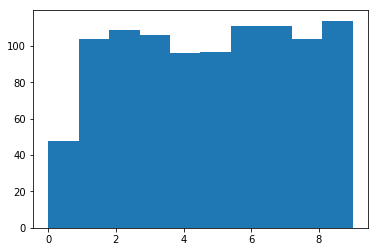

In [11]:
plt.hist([int(r[-1]) for r in res])

In [12]:
res[2]

(['3', '/', '1', '/', '6', '*', '1', '+', '1'],
 ['1', '2', '3', '4', '5', '6', '7', '8'],
 8,
 '1')

In [107]:
with open('analy_clustering.tsv', 'w') as f:
    for r in res:
        to_write = [' '.join(r[0]), ' '.join(r[1]), str(r[2]), str(r[3])]
        f.write('\t'.join(to_write)+'\n')

# load

In [108]:
expr

['4', '/', '9', '*', '9', '/', '5', '+', '9']

In [109]:
seq = '4/9*9/5+9'

In [110]:
syn_dis = [1, 2, 3, 4, 5, 6, 7, 8]

In [111]:
seq_len = len(seq)
seq_len

9

In [112]:
npops = np.array(list(range(6)) + list(range(6))) 

In [113]:
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}
exprs = []
vals = []
i = 0
with open('feval-analy_clustering-sarnn.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if 'all' not in line_json:
            exprs.append(line_json['expr'])
#             val = to_value_sd(syn_dis[:-2], line_json['expr'][:-2])[1]
            val = to_value_sd(syn_dis, line_json['expr'])[1]
            vals.append(val)
            continue
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])
        i += 1
        i %= seq_len

In [114]:
vals[0]

'1'

In [115]:
exprs[0]

['8', '/', '4', '*', '4', '*', '2', '+', '1']

In [116]:
len(prob_action[0])

1000

In [117]:
remain = 10
step = []
for i in range(seq_len):
    step.append(np.array(mem[i]))
mean_mem_dist = []
for i in range(seq_len):
    mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])

In [118]:
step = []
for i in range(seq_len):
    step.append(np.array(prob_action[i]))
mean_dist = []
for i in range(seq_len):
    mean_dist.append(step[i].sum(0)/step[i].shape[0])

In [119]:
for i in range(seq_len):
    mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
mem_whole = np.hstack(mean_mem_dist)

([], <a list of 0 Text yticklabel objects>)

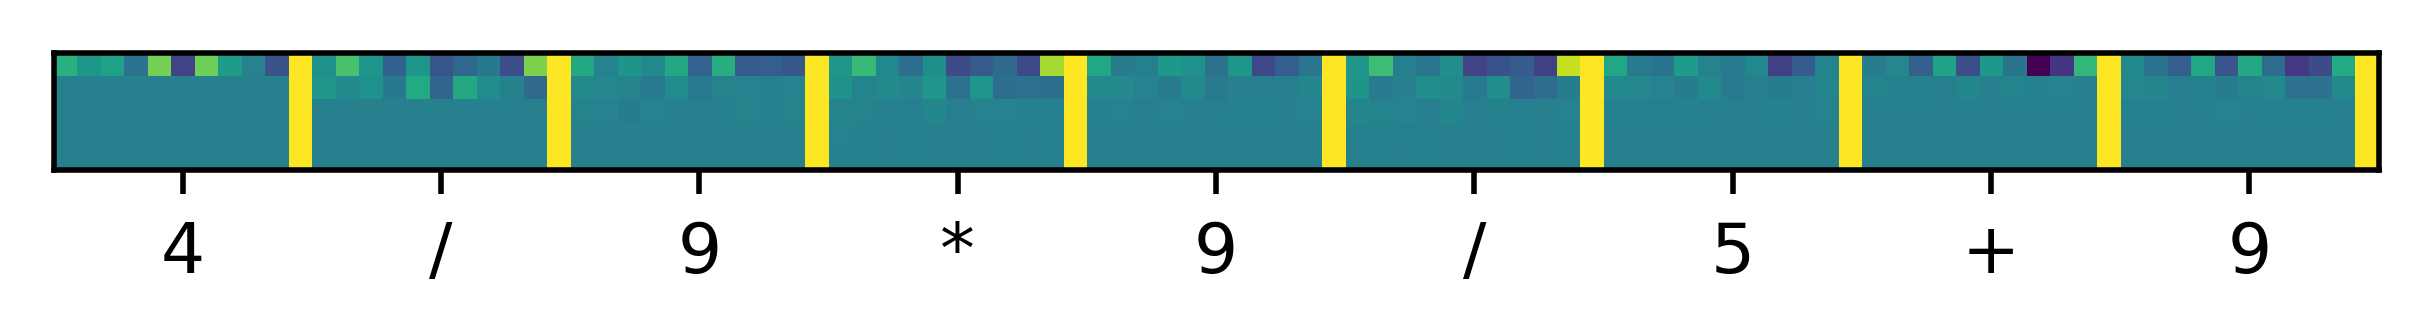

In [120]:
fig, ax = plt.subplots()
fig.dpi = 500
plt.imshow(mem_whole)
plt.xticks(np.arange(5, mem_whole.shape[1], 11), list(seq))
plt.yticks([])

# consistency check

In [121]:
def sample_and_draw():
    remain = 10
    step = []
    for i in range(seq_len):
        step.append(np.array(mem[i]))
    mean_mem_dist = []
    idx = random.choice(range(len(exprs)))
    print(idx)
    for i in range(seq_len):
        mean_mem_dist.append(step[i][idx][:, :remain])
    step = []
    for i in range(seq_len):
        step.append(np.array(prob_action[i]))
    mean_dist = []
    for i in range(seq_len):
        mean_dist.append(step[i].sum(0)/step[i].shape[0])
    for i in range(seq_len):
        mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
    mem_whole = np.hstack(mean_mem_dist)
    fig, ax = plt.subplots()
    fig.dpi = 500
    plt.imshow(mem_whole)
    plt.xticks(np.arange(5, mem_whole.shape[1], 11), exprs[idx])
    plt.yticks([])

979


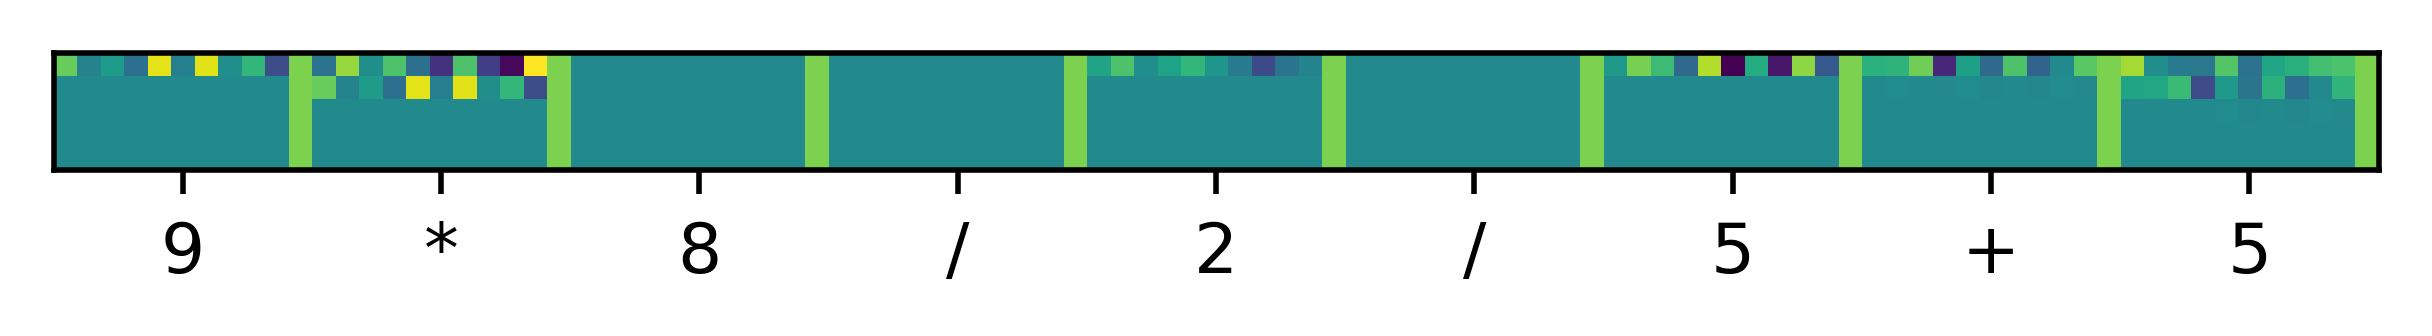

In [122]:
sample_and_draw()

In [123]:
print(exprs[299])
np.array(mem[4][299])[:,:5]

['7', '*', '3', '/', '7', '*', '7', '+', '2']


array([[-2.34141976e-01,  1.97776288e-01,  1.28894851e-01,
         9.22406197e-01,  5.15364647e-01],
       [ 4.11727116e-04,  1.21985584e-04, -1.85228157e-04,
         9.77344753e-05,  1.87022757e-04],
       [ 9.73369380e-19,  3.75448104e-19, -1.12165340e-18,
         7.40155215e-19, -4.12029933e-19],
       [ 1.34174550e-19,  7.68597161e-20, -1.42481150e-19,
         1.07777407e-19, -1.90554706e-20],
       [ 2.26880991e-22,  1.29675960e-22, -2.41379825e-22,
         1.82800037e-22, -3.25023693e-23]])

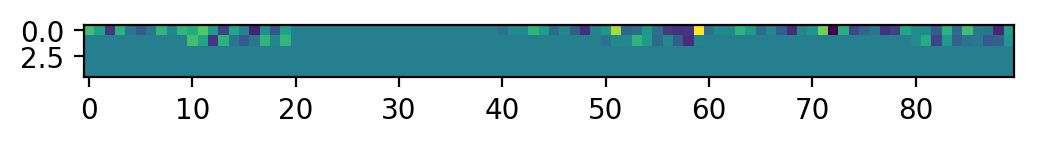

In [124]:
fig, ax = plt.subplots()
fig.dpi = 200
plt.imshow(np.hstack([np.array(mem[i][299])[:,:10] for i in range(seq_len)]))

# push

In [125]:
push = [mean_dist[t][:6].sum() for t in range(seq_len)]

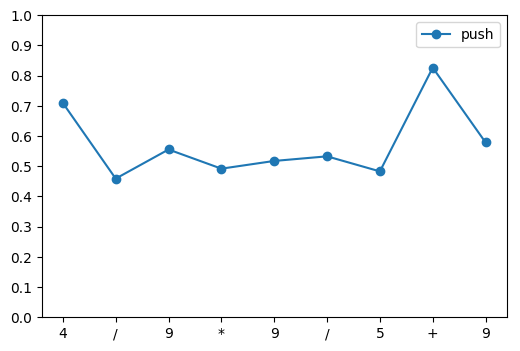

In [126]:
fig, ax = plt.subplots()
fig.dpi = 100
# plt.plot(np.arange(seq_len), 
#          np.array([in_l[i] for i in in_l.keys()])/ngates,
#         label='in_l', marker='|')
# plt.plot(np.arange(seq_len), 
#          np.array([in_r[i] for i in in_r.keys()])/ngates,
#         label='in_r')
# plt.plot(np.arange(seq_len), 
#          np.array([forget_l[i] for i in forget_l.keys()])/ngates,
#         label='forget_l',marker='x')
# plt.plot(np.arange(seq_len), 
#          np.array([forget_r[i] for i in forget_r.keys()])/ngates,
#         label='forget_r')
plt.plot(np.arange(seq_len), 
         push,
        label='push',marker='o')

plt.legend()
plt.xticks(np.arange(0, seq_len, 1), list(seq))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

# clustering

In [127]:
X.shape

(500, 100)

In [128]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([mem[8][i][0] for i in range(len(mem[8]))])
X_embedded = TSNE(n_components=2).fit_transform(X)

In [129]:
X_embedded.shape

(1000, 2)

In [130]:
X_norm.shape[0]

500

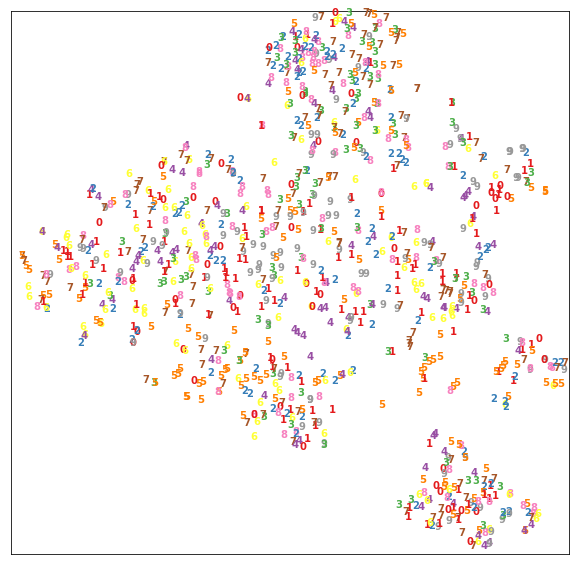

In [131]:
x_min, x_max = X_embedded.min(0) - 1, X_embedded.max(0) + 1 
X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=plt.cm.Set1(int(vals[i]) * 0.1), 
             fontdict={'weight': 'bold', 'size': 10})
plt.xticks([])
plt.yticks([])
plt.show()

# another 

In [132]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
seq_len = len(seq)
seq_len
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}
vals = []
exprs = []
i = 0
nc = 0
nt = 0
with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['type'] != 'actions':
            assert line_json['type'] == 'input'
            nc += line_json['is_correct']
            nt += 1
            
            exprs.append(line_json['expr'])
            val = to_value_sd(syn_dis[:6], line_json['expr'][:7])[1]
            vals.append(val)
            continue 
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])        
        i += 1
        i %= seq_len
remain = 4
step = []
for i in range(seq_len):
    step.append(np.array(mem[i]))
mean_mem_dist = []
for i in range(seq_len):
    mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])
for i in range(seq_len):
    mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
mem_whole = np.hstack(mean_mem_dist)
mem_whole.shape

(5, 275)

In [133]:
nc/nt

0.992

In [134]:
''.join(exprs[4][:7])

'3+7*9*9'

In [135]:
vals[4]

'0'

In [136]:
X = np.array([mem[8][i][0] for i in range(len(mem[8]))])
X_embedded = TSNE(n_components=2).fit_transform(X)

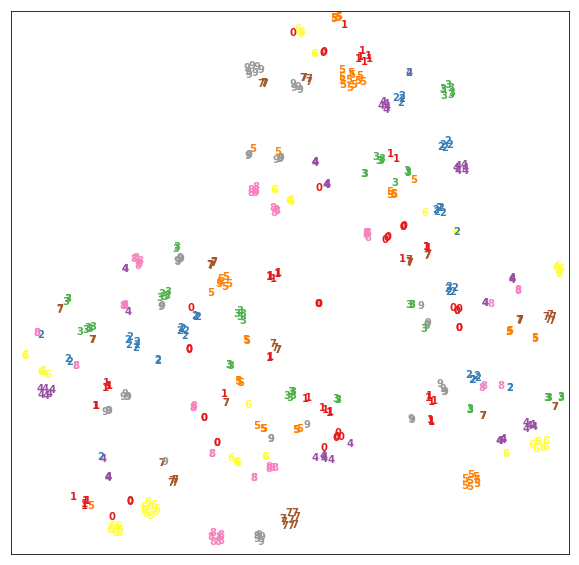

In [137]:
x_min, x_max = X_embedded.min(0) - 1, X_embedded.max(0) + 1 
X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(10, 10))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=plt.cm.Set1(int(vals[i]) * 0.1), 
             fontdict={'weight': 'bold', 'size': 10})
plt.xticks([])
plt.yticks([])
plt.show()

# 验证是否每个 + - 号后边push的是前边所有项的运算结果

In [56]:
def cluster_on(t, cell_idx):
    print_num = 5
    printed = 0
    
    seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
    seq_len = len(seq)
    seq_len
    ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
    syn_dis = [int(d) for d in ds]
    prob_action = {i:[] for i in range(seq_len)}
    mem = {i:[] for i in range(seq_len)}
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    
    colors = {
        '0': 'r',
        '1': 'orange',
        '2': 'gold',
        '3': 'tan',
        '4': 'seagreen',
        '5': 'b',
        '6': 'purple',
        '7': 'brown',
        '8': 'hotpink',
        '9': 'silver'}
    
    with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1

                exprs.append(line_json['expr'])
                ch_pos = t + 1 if t % 2 == 0 else t
                d_pos = ch_pos - 1
                val = to_value_sd(syn_dis[:d_pos], 
                                  line_json['expr'][:ch_pos])[1]
                if printed < print_num:
                    print(line_json['expr'][:ch_pos], syn_dis[:d_pos], val)
                    printed += 1
                vals.append(val)
                continue 

            prob_action[i].append(line_json['all'])
            mem[i].append(line_json['mem'])        
            i += 1
            i %= seq_len

    X = np.array([mem[t][i][cell_idx] for i in range(len(mem[t]))])
    print(X[:print_num, :10])
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
#         plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=plt.cm.Set1(int(vals[i]) * 0.1), 
#                  fontdict={'weight': 'bold', 'size': 10})
        plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=colors[str(vals[i])], 
                 fontdict={'weight': 'bold', 'size': 25})
    ax = plt.gca() # 获取当前的axes
#     ax.spines['left'].set_visible(False)  #去掉上边框
#     ax.spines['bottom'].set_visible(False) #去掉右边框
    ax.spines['top'].set_visible(False) #去掉右边框
    ax.spines['right'].set_visible(False) #去掉右边框
    plt.xticks(np.arange(0,1.2,0.2), [])
    plt.yticks(np.arange(0,1.2,0.2), [])
    plt.
    plt.show()

['1'] [] 1
['5'] [] 5
['8'] [] 8
['8'] [] 8
['3'] [] 3
[[ 0.09103509  1.18435574 -0.40353167  0.77473998 -0.3276549  -0.23641478
  -0.25708514 -0.72057414 -0.95151687 -0.54760295]
 [ 0.52174324  1.23504937  0.48017773 -1.41129732  1.74954665 -1.22046328
   0.16469651 -1.14261198  1.17721868 -0.73723143]
 [ 0.77401322  0.12523071 -1.14191246  0.95349038 -0.25689209 -0.27146634
   0.64079952  0.56531137 -0.43853211  0.65576696]
 [ 0.77401322  0.12523071 -1.14191246  0.95349038 -0.25689209 -0.27146634
   0.64079952  0.56531137 -0.43853211  0.65576696]
 [-0.58199173  0.02745392  1.65018654 -0.02316591  0.5312171  -1.0417254
   0.99279064 -0.18876562 -1.31887162 -1.7367264 ]]


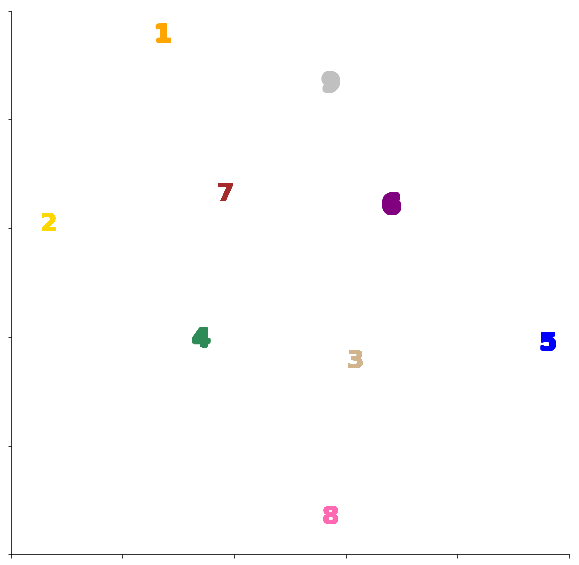

In [57]:
cluster_on(0, 0)

['1', '-', '1'] [1, 5] 0
['5', '-', '5'] [1, 5] 0
['8', '-', '6'] [1, 5] 2
['8', '+', '8'] [1, 5] 6
['3', '+', '7'] [1, 5] 0
[[ 0.76443744  0.3098956  -1.64539611  0.68099374 -0.51304674  1.07014596
  -0.55408639 -0.70282406 -0.25313479  0.59197652]
 [ 1.55811596 -0.42688978 -1.40217948  0.07387338 -0.98490828 -1.38378537
  -0.05370995 -0.94020528 -0.1701801  -0.46757603]
 [ 1.36541009 -0.38339287  0.08560544  0.47459838 -0.25223988  0.48028213
   0.35954037 -0.62207681 -0.77422071 -1.39189827]
 [ 0.36548045  0.73228317  0.25957653 -0.78380185  1.29715133  0.06821766
   0.01327974  0.11914714  0.77630097  1.64052308]
 [ 0.69860506  0.38595137 -1.43099701  0.122212   -0.32421204  0.39619216
  -0.78657663  0.35558274 -0.22970313  0.41905111]]


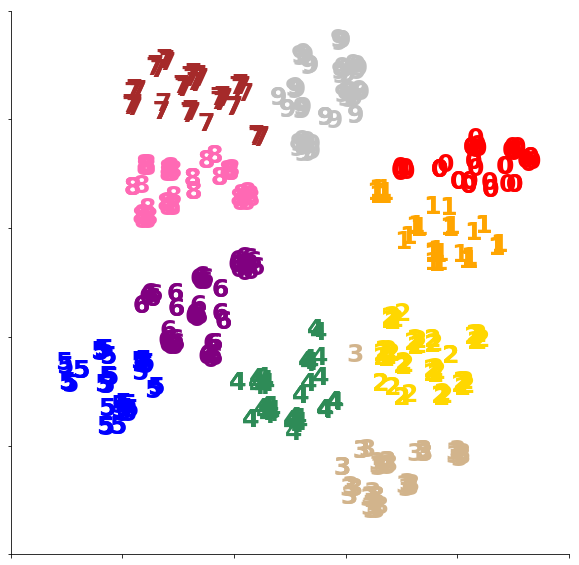

In [58]:
cluster_on(2, 0)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.44699872  0.75146466 -1.20618296  0.20964776 -1.3355093  -0.68441582
  -0.06062535 -1.11081541 -0.63031447  1.14667046]
 [ 0.58145124  1.0492574   0.48956519 -1.441329   -0.10132145 -1.03319466
  -0.58103859 -0.82362938 -0.20368887  1.16896248]
 [ 1.02490973 -0.16164388 -0.19091204 -0.07989587 -0.39085647 -0.86011219
  -0.03784221 -0.24943657  0.13862249  1.8399421 ]
 [ 1.57744443  0.07719538 -0.82304156  0.15996058 -1.88466489 -0.20659184
   0.16686305 -1.06627774  0.56710231  0.54767364]
 [-0.26514    -0.6165179   0.09328311  0.47006956  0.98437935 -0.49537155
   0.60652238  0.60905629  0.17756101  0.59913325]]


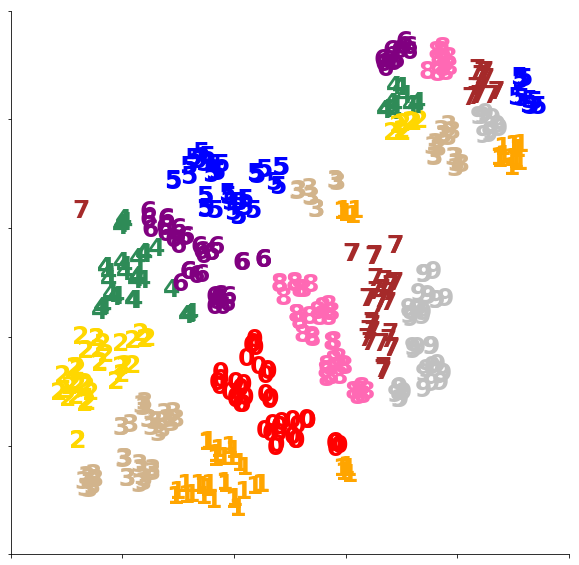

In [59]:
cluster_on(4, 0)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.88416624e-01  5.17141640e-01 -4.37702835e-01  7.69149721e-01
  -7.51246810e-01  3.12622607e-01 -1.90200299e-01 -4.17003602e-01
  -7.58044541e-01  2.91299105e-01]
 [ 7.40018904e-01  9.01024282e-01  3.39055538e-01 -1.30989158e+00
  -3.76166344e-01 -1.39994633e+00 -4.66852248e-01 -9.15502906e-01
  -2.39567652e-01  1.33445966e+00]
 [ 6.89218998e-01 -4.15999919e-01 -2.70593733e-01  3.85751635e-01
  -1.03304482e+00 -3.61535668e-01  7.86744282e-02 -1.40522987e-01
   3.70958596e-02  1.74502397e+00]
 [ 8.21400702e-01 -4.59880561e-01  2.89513469e-01  9.54848481e-04
  -5.53351104e-01 -3.70677084e-01  2.21232191e-01  1.38796195e-01
   4.50875044e-01  1.36693609e+00]
 [-2.68568248e-01 -4.23972726e-01 -1.21514392e+

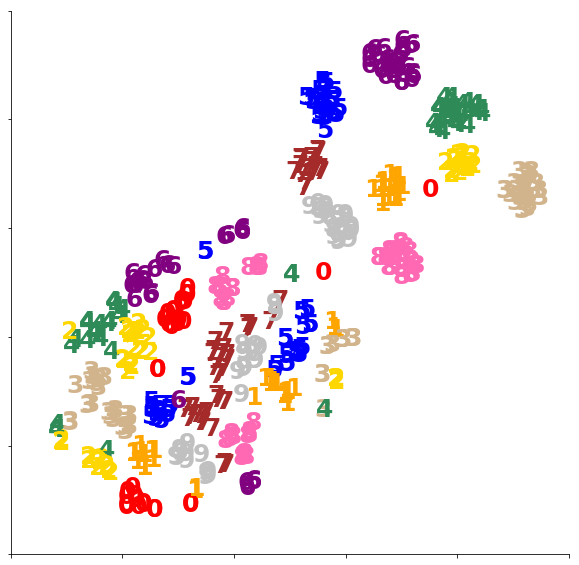

In [60]:
cluster_on(6, 0)

['1', '-', '1', '/', '1', '*', '9', '-', '1'] [1, 5, 1, 2, 3, 4, 6, 7] 0
['5', '-', '5', '*', '6', '/', '6', '+', '4'] [1, 5, 1, 2, 3, 4, 6, 7] 9
['8', '-', '6', '*', '5', '*', '6', '-', '1'] [1, 5, 1, 2, 3, 4, 6, 7] 7
['8', '+', '8', '/', '1', '*', '8', '+', '8'] [1, 5, 1, 2, 3, 4, 6, 7] 6
['3', '+', '7', '*', '9', '*', '9', '-', '2'] [1, 5, 1, 2, 3, 4, 6, 7] 8
[[ 0.64763623 -0.0220614  -1.4939115   0.8370834  -0.59499127  1.09289002
  -0.3651939  -0.64588559 -0.5163368   0.26109481]
 [ 0.24795367  0.67914689 -1.27016997  1.14283359 -0.08003442 -0.80824226
  -0.42320606 -0.05253501 -0.22738007 -0.5209201 ]
 [-0.06555617  0.96497196  0.82901472  0.66620505  1.27518868 -1.07187808
   0.41304225 -0.30429658  0.58293402  0.90488815]
 [ 0.2238948   0.96426964  0.0837046  -0.92194843  1.34874821  0.39026648
  -0.33310682  0.11798265  0.71800661  1.83064044]
 [ 0.11996258 -0.1226316  -1.34146726  1.44579589 -0.30531719 -1.03082836
   0.67744917 -1.00907981 -0.32162905  1.09541309]]


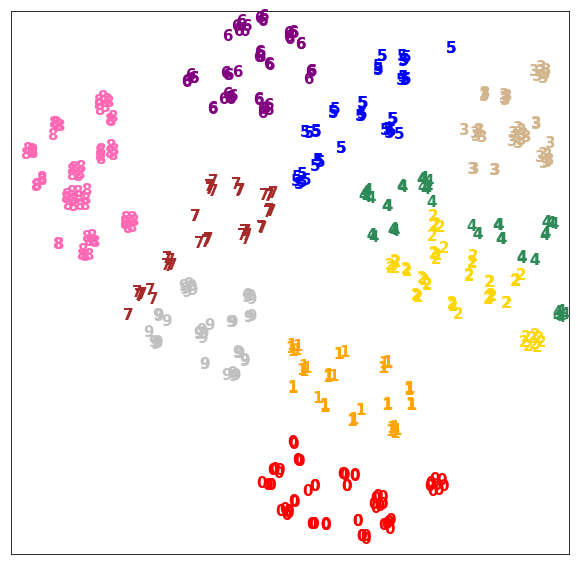

In [274]:
cluster_on(8, 0)

['1', '-', '1', '/', '1', '*', '9', '-', '1', '/', '7', '*', '6', '/', '4', '-', '3'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9] 6
['5', '-', '5', '*', '6', '/', '6', '+', '4', '/', '4', '*', '1', '/', '7', '-', '3'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9] 2
['8', '-', '6', '*', '5', '*', '6', '-', '1', '/', '1', '/', '6', '*', '7', '+', '2'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9] 0
['8', '+', '8', '/', '1', '*', '8', '+', '8', '/', '8', '/', '5', '/', '4', '+', '5'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9] 3
['3', '+', '7', '*', '9', '*', '9', '-', '2', '*', '2', '*', '5', '*', '7', '-', '6'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9] 4
[[-0.03999179 -0.73446286 -0.12317513 -0.21979386  1.69041812  0.21047498
   0.29162338 -0.28395265  0.2267061   0.36288607]
 [ 0.20360877 -1.58541191  0.09100317  0.92129052 -0.99663293 -0.75208962
   0.48439389 -0.38269651 -2.21673894 -0.26701063]
 [ 0.04341918  0.55344772 -1.51674426  0.44226161 -0.87665951  1.

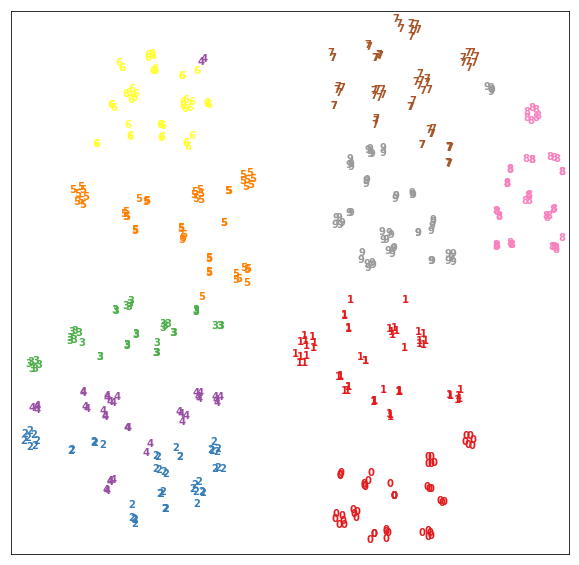

In [203]:
cluster_on(16, 0)

['1', '-', '1', '/', '1', '*', '9', '-', '1', '/', '7', '*', '6', '/', '4', '-', '3', '*', '5', '*', '2', '*', '3', '/', '8', '+', '5'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11] 4
['5', '-', '5', '*', '6', '/', '6', '+', '4', '/', '4', '*', '1', '/', '7', '-', '3', '/', '7', '/', '6', '/', '3', '/', '2', '-', '4'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11] 1
['8', '-', '6', '*', '5', '*', '6', '-', '1', '/', '1', '/', '6', '*', '7', '+', '2', '/', '6', '*', '6', '*', '2', '*', '4', '-', '5'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11] 9
['8', '+', '8', '/', '1', '*', '8', '+', '8', '/', '8', '/', '5', '/', '4', '+', '5', '/', '2', '*', '3', '/', '5', '/', '3', '-', '2'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11] 6
['3', '+', '7', '*', '9', '*', '9', '-', '2', '*', '2', '*', '5', '*', '7', '-', '6', '*', '5', '*', '5', '*', '2', '*', '4'

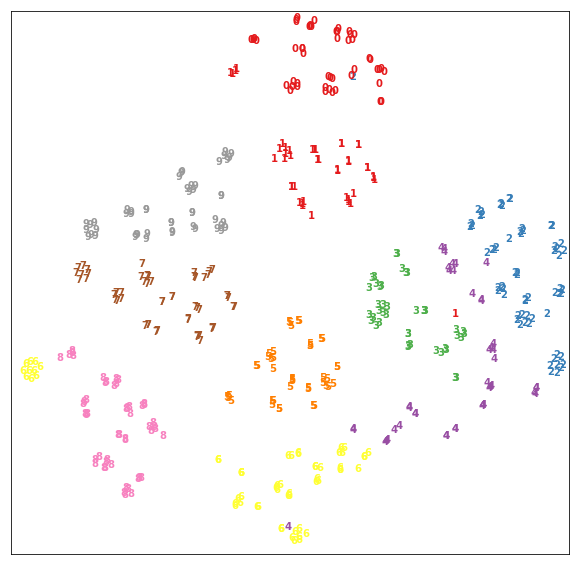

In [204]:
cluster_on(26, 0)

# 查看在每个项内计算过程中 push的是否为项内中间运算结果

In [36]:
def cluster_on(t, cell_idx, term_begin, term_end):
    seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
    seq_len = len(seq)
    seq_len
    ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
    syn_dis = [int(d) for d in ds]
    prob_action = {i:[] for i in range(seq_len)}
    mem = {i:[] for i in range(seq_len)}
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
                node_lst = line_json['expr'][term_begin: term_end]
                ds = [i+1 for i in range(len(node_lst)-1)]
                
                exprs.append(line_json['expr'])
                val = to_value_sd(ds, node_lst)[1] if len(node_lst) > 1 else node_lst[0]
                
                vals.append(val)
                continue 

            prob_action[i].append(line_json['all'])
            mem[i].append(line_json['mem'])        
            i += 1
            i %= seq_len

    X = np.array([mem[t][i][cell_idx] for i in range(len(mem[t]))])
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]),
                 color=plt.cm.Set1(int(np.abs(ord(vals[i])-ord('0'))) * 0.1), 
                 fontdict={'weight': 'bold', 'size': 25})
    plt.xticks([])
    plt.yticks([])
    plt.show()

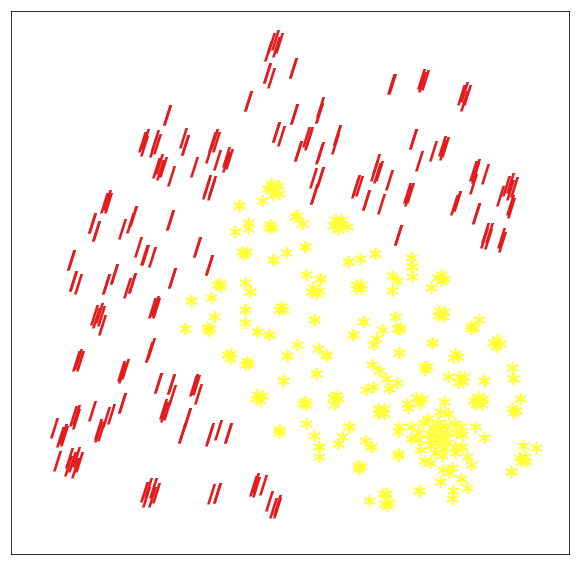

In [37]:
cluster_on(3, 1, 3, 3+1)

## 项内计算存储的内容发生了耦合？

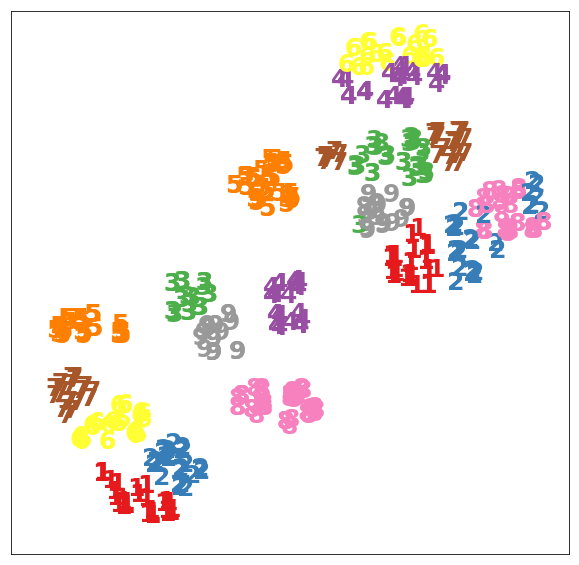

In [30]:
cluster_on(3, 0, 2, 2+1)

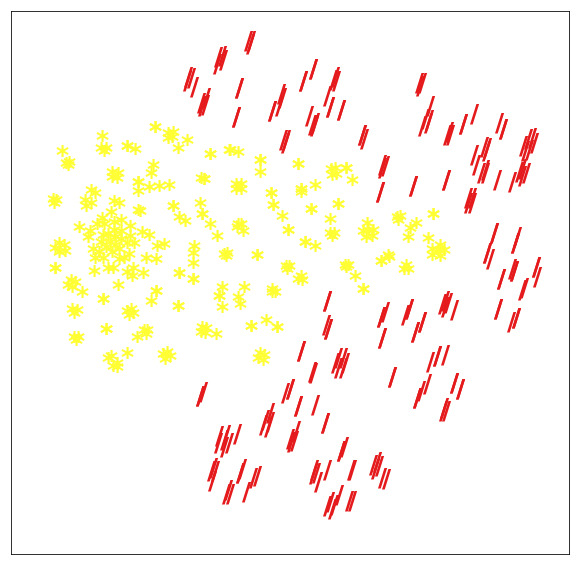

In [31]:
cluster_on(3, 1, 3, 3+1)

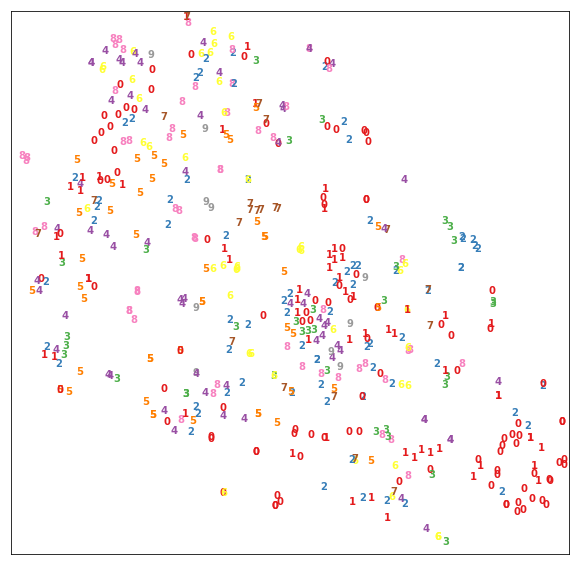

In [55]:
cluster_on(4, 0, 2, 4+1)

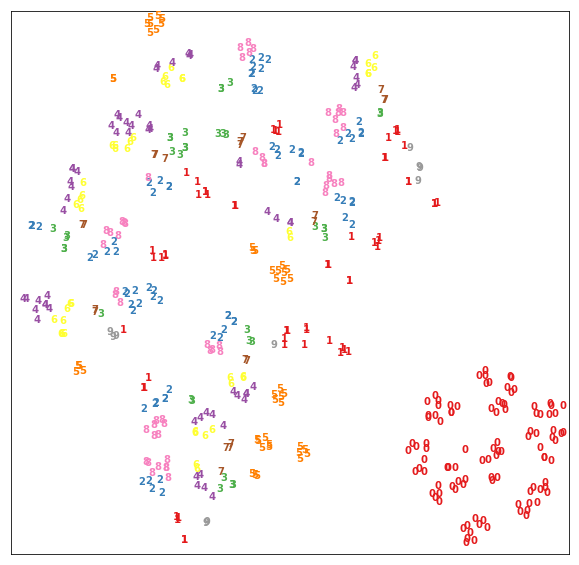

In [73]:
cluster_on(4, 0, 2, 4+1)

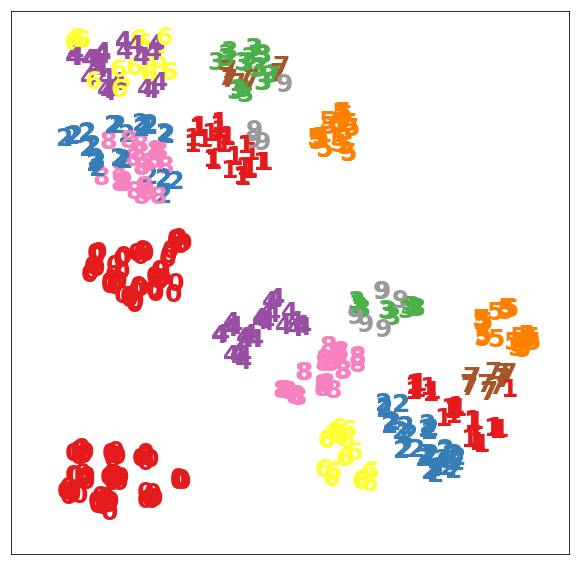

In [32]:
cluster_on(5, 0, 2, 4+1)

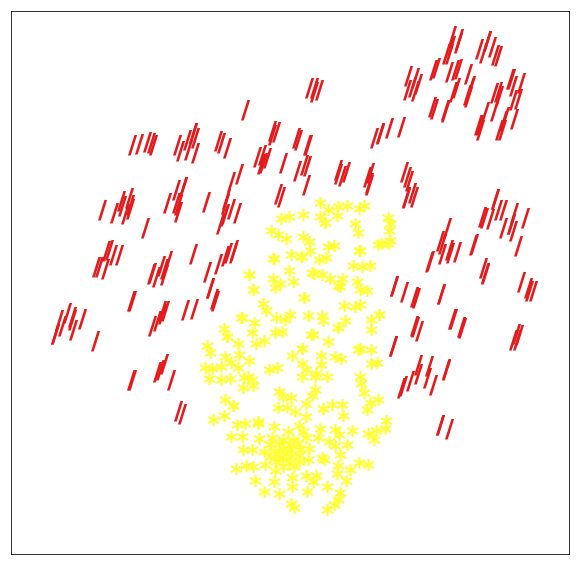

In [33]:
cluster_on(5, 1, 5, 5+1)

# 6 * 后是否推入 6$*$?

In [57]:
def cluster_on(t, cell_idx, num_pos, op_pos):
    seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
    seq_len = len(seq)
    seq_len
    ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
    syn_dis = [int(d) for d in ds]
    prob_action = {i:[] for i in range(seq_len)}
    mem = {i:[] for i in range(seq_len)}
    lbls = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
#                 node_lst = line_json['expr'][term_begin: term_end]
#                 ds = [i+1 for i in range(len(node_lst)-1)]
                
#                 exprs.append(line_json['expr'])
                
#                 val = to_value_sd(ds, node_lst)[1] if len(node_lst) > 1 else node_lst[0]
                lbl = line_json['expr'][num_pos] + line_json['expr'][op_pos]
#                 vals.append(val)
                lbls.append(lbl)
                continue 

            prob_action[i].append(line_json['all'])
            mem[i].append(line_json['mem'])        
            i += 1
            i %= seq_len

    X = np.array([mem[t][i][cell_idx] for i in range(len(mem[t]))])
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 1, X_embedded.max(0) + 1 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(lbls[i]),
                 color=plt.cm.Set1(int(np.abs(ord(vals[i])-ord('0'))) * 0.1), 
                 fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([])
    plt.yticks([])
    plt.show()

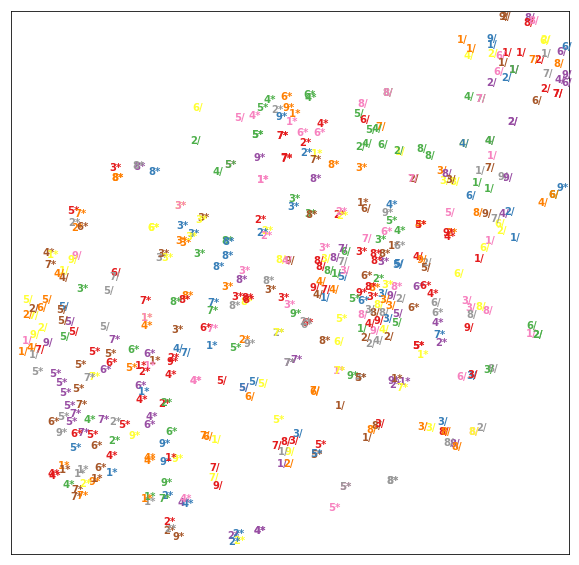

In [58]:
cluster_on(4, 0, 2, 3)

# 6 $*$ 3 处是否两个cell代表 6 $*$ 3运算结果？

In [62]:
def cluster_on(t, cell_begin, cell_end, term_begin, term_end):
    print_num = 5
    printed = 0
    
    seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
    seq_len = len(seq)
    seq_len
    ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
    syn_dis = [int(d) for d in ds]
    prob_action = {i:[] for i in range(seq_len)}
    mem = {i:[] for i in range(seq_len)}
    vals = []
    exprs = []
    i = 0
    nc = 0
    nt = 0
    
    colors = {
        '0': 'r',
        '1': 'orange',
        '2': 'gold',
        '3': 'tan',
        '4': 'seagreen',
        '5': 'b',
        '6': 'purple',
        '7': 'brown',
        '8': 'hotpink',
        '9': 'silver',
        '*': 'orange',
        '/': 'orchid'}
    
    with open('feval-analy_d23_ne10-sarnn.txt', 'r') as f:
        for line in f:
            line_json = json.loads(line)
            if line_json['type'] != 'actions':
                assert line_json['type'] == 'input'
                nc += line_json['is_correct']
                nt += 1
                
                node_lst = line_json['expr'][term_begin: term_end]
                ds = syn_dis[term_begin: term_end-1]
#                 ds = [i+1 for i in range(len(node_lst)-1)]
                
                exprs.append(line_json['expr'])
                val = to_value_sd(ds, node_lst)[1] if len(node_lst) > 1 else node_lst[0]
                if printed < print_num:
                    print(node_lst, ds, val)
                    printed += 1
                
                vals.append(val)
                continue 

            prob_action[i].append(line_json['all'])
            mem[i].append(line_json['mem'])        
            i += 1
            i %= seq_len

    X = np.array([np.array(mem[t][i][cell_begin: cell_end]).reshape(-1)  
                  for i in range(len(mem[t]))])
    print(X[:printed, :10])
    
    X_embedded = TSNE(n_components=2).fit_transform(X)
    x_min, x_max = X_embedded.min(0) - 5, X_embedded.max(0) + 5 
    X_norm = (X_embedded - x_min) / (x_max - x_min)  # 归一化
    plt.figure(figsize=(10, 10))
    for i in range(X_norm.shape[0]):
#         plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]),
#                  color=plt.cm.Set1(int(np.abs(ord(vals[i])-ord('0'))) * 0.1), 
#                  fontdict={'weight': 'bold', 'size': 10})
        plt.text(X_norm[i, 0], X_norm[i, 1], str(vals[i]), color=colors[str(vals[i])], 
                 fontdict={'weight': 'bold', 'size': 25})
    ax = plt.gca() # 获取当前的axes
#     ax.spines['left'].set_visible(False)  #去掉上边框
#     ax.spines['bottom'].set_visible(False) #去掉右边框
    ax.spines['top'].set_visible(False) #去掉右边框
    ax.spines['right'].set_visible(False) #去掉右边框
    plt.xticks(np.arange(0,1.2,0.2), [])
    plt.yticks(np.arange(0,1.2,0.2), [])
    plt.show()

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.44699872  0.75146466 -1.20618296  0.20964776 -1.3355093  -0.68441582
  -0.06062535 -1.11081541 -0.63031447  1.14667046]
 [ 0.58145124  1.0492574   0.48956519 -1.441329   -0.10132145 -1.03319466
  -0.58103859 -0.82362938 -0.20368887  1.16896248]
 [ 1.02490973 -0.16164388 -0.19091204 -0.07989587 -0.39085647 -0.86011219
  -0.03784221 -0.24943657  0.13862249  1.8399421 ]
 [ 1.57744443  0.07719538 -0.82304156  0.15996058 -1.88466489 -0.20659184
   0.16686305 -1.06627774  0.56710231  0.54767364]
 [-0.26514    -0.6165179   0.09328311  0.47006956  0.98437935 -0.49537155
   0.60652238  0.60905629  0.17756101  0.59913325]]


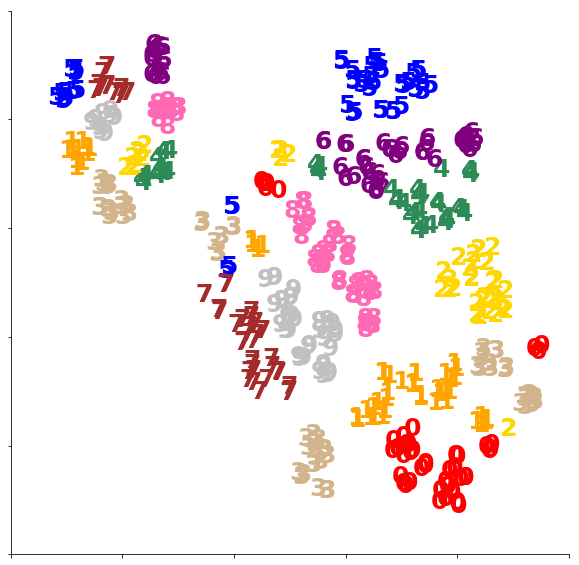

In [50]:
cluster_on(4, 0, 0+1, 0, 4+1)

['1'] [] 1
['5'] [] 5
['6'] [] 6
['8'] [] 8
['7'] [] 7
[[ 2.17716753e-01  1.38334429e+00 -9.36174870e-01 -1.55862153e-01
   2.36060515e-01 -2.37836108e-01  5.44413447e-01 -2.09321547e+00
  -1.93283153e+00  2.75384402e+00]
 [ 2.19539797e-04  5.39654691e-04 -8.78891369e-05 -2.46795447e-04
  -7.11797155e-04 -5.21406007e-04 -2.58460059e-04 -3.82312399e-04
  -3.46085028e-04  1.10681485e-05]
 [-4.42619144e-04 -4.57469636e-04  1.50768892e-05  7.33722642e-04
  -1.71432781e-04  5.49333752e-04  7.98408408e-04  5.33691549e-04
  -4.05448052e-04 -6.87362975e-04]
 [-2.34243453e-01  3.45855296e-01  6.36001453e-02 -2.72203207e-01
   3.86292666e-01 -1.46620780e-01 -3.10202169e+00 -4.54560518e-01
   1.38475955e-01  1.58403122e+00]
 [-5.92987810e-04  3.17063503e-04  1.33680383e-04  4.81812807e-04
   1.81166368e-04 -1.36915754e-04  1.69863182e-04 -4.50683874e-04
   3.52938041e-05 -6.84479659e-04]]


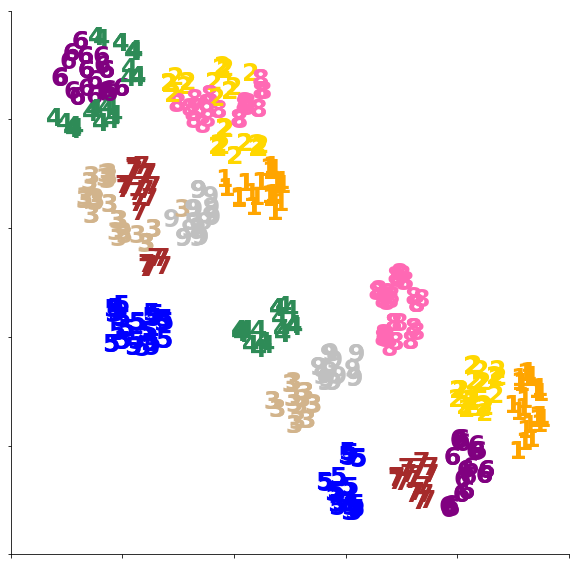

In [52]:
cluster_on(3, 0, 0+1, 2, 2+1)

['/'] [] /
['*'] [] *
['*'] [] *
['/'] [] /
['*'] [] *
[[ 7.64436185e-01  3.09895098e-01 -1.64539349e+00  6.80992663e-01
  -5.13045907e-01  1.07014430e+00 -5.54085493e-01 -7.02822924e-01
  -2.53134370e-01  5.91975570e-01]
 [ 3.56902137e-06 -9.77834020e-07 -3.21183325e-06  1.69214402e-07
  -2.25603162e-06 -3.16969954e-06 -1.23028059e-07 -2.15363480e-06
  -3.89814630e-07 -1.07102994e-06]
 [ 1.25363789e-04 -3.52008428e-05  7.85977954e-06  4.35747861e-05
  -2.31591584e-05  4.40966323e-05  3.30108487e-05 -5.71153723e-05
  -7.10843160e-05 -1.27795778e-04]
 [ 3.65476787e-01  7.32275844e-01  2.59573936e-01 -7.83793986e-01
   1.29713833e+00  6.82169795e-02  1.32796057e-02  1.19145952e-01
   7.76293218e-01  1.64050663e+00]
 [ 4.60994691e-08  2.54681147e-08 -9.44284650e-08  8.06451084e-09
  -2.13940670e-08  2.61438817e-08 -5.19045287e-08  2.34641533e-08
  -1.51576227e-08  2.76522965e-08]]


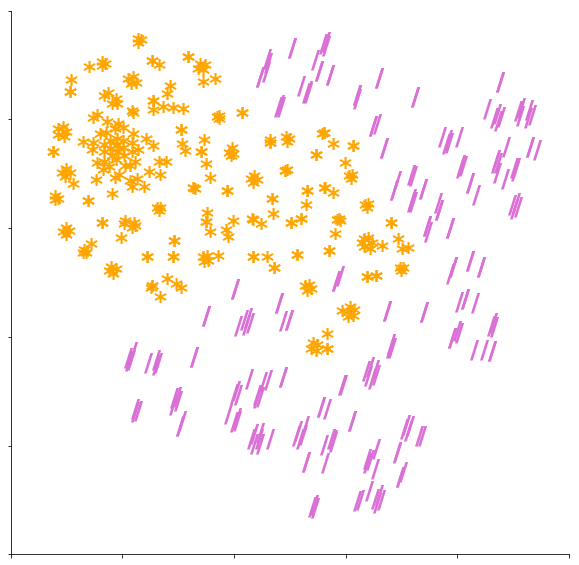

In [53]:
cluster_on(3, 1, 1+1, 3, 3+1)

['1', '/', '1'] [1, 2] 0
['5', '*', '6'] [1, 2] 0
['6', '*', '5'] [1, 2] 0
['8', '/', '1'] [1, 2] 0
['7', '*', '9'] [1, 2] 3
[[ 5.91982214e-04  3.08006507e-04 -5.11476654e-04  9.64569990e-05
  -4.78402653e-04 -1.27853651e-04 -3.50050192e-04 -2.84732632e-05
  -3.16098362e-04  2.59728782e-04]
 [ 1.16726041e+00  2.82649606e-01 -3.67203802e-01 -9.76680815e-01
  -9.60165024e-01 -2.60063457e+00 -4.45742249e-01 -7.79275000e-01
  -8.15908194e-01  2.67074704e+00]
 [ 2.23140130e-04 -2.01001458e-04 -4.00583267e-05  1.45554528e-04
  -8.22617076e-05  1.07665306e-04  1.08227679e-04 -1.04030252e-04
   1.86793026e-04  1.12986447e-04]
 [ 2.46611686e-04 -1.30151704e-04 -2.85103364e-04  7.44874997e-05
  -5.04468742e-04  5.28392775e-05  6.65178886e-05 -4.84412849e-05
   1.54383059e-04  1.73553970e-04]
 [ 3.54799195e-05  4.49444924e-04  3.14724020e-04  9.81663397e-05
   5.19099296e-04 -6.41057704e-05 -6.71660819e-05 -7.84624062e-05
   2.41868183e-04 -6.23217027e-04]]


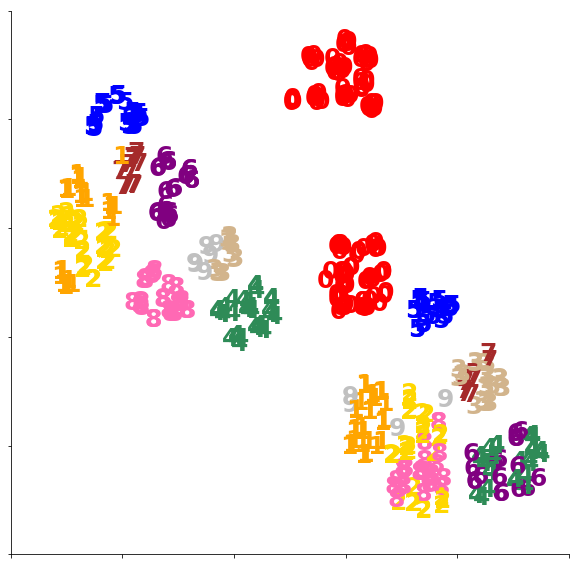

In [63]:
cluster_on(5, 0, 0+1, 2, 4+1)

['*'] [] *
['/'] [] /
['*'] [] *
['*'] [] *
['*'] [] *
[[ 5.45835732e-08  2.88484561e-08 -4.67241428e-08  8.32151326e-09
  -5.00109074e-08 -2.46273437e-08 -2.49142018e-09 -4.28797264e-08
  -2.45430432e-08  4.44168897e-08]
 [ 5.81451118e-01  1.04925716e+00  4.89565104e-01 -1.44132876e+00
  -1.01321436e-01 -1.03319442e+00 -5.81038475e-01 -8.23629260e-01
  -2.03688845e-01  1.16896224e+00]
 [ 1.54091662e-09 -2.58632615e-10 -2.56796084e-10 -6.74846290e-11
  -5.64100877e-10 -1.14793464e-09 -1.94163331e-11 -4.00356248e-10
   1.22500968e-10  2.42372233e-09]
 [ 5.11224840e-08  2.52352828e-09 -2.66597731e-08  5.15908116e-09
  -6.10262347e-08 -6.69178180e-09  5.40699530e-09 -3.45452342e-08
   1.83985236e-08  1.77953172e-08]
 [-2.63872882e-11 -4.91393384e-13  6.08638227e-12  2.67297764e-11
   2.57806710e-11 -1.45338091e-11  1.77520654e-11 -4.18737614e-12
   4.67484688e-12 -1.28172707e-11]]


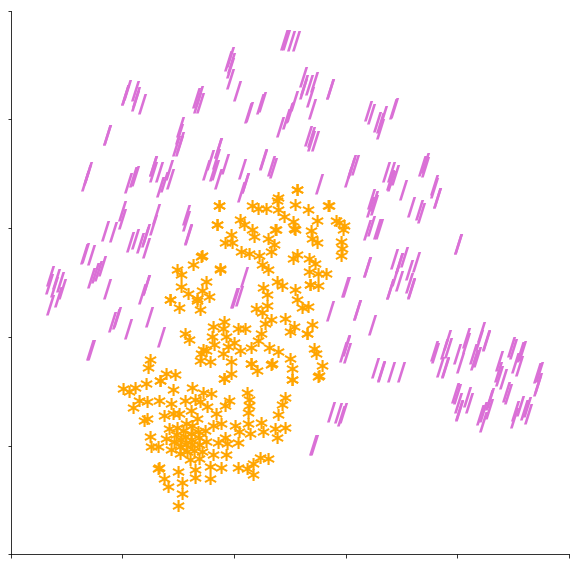

In [55]:
cluster_on(5, 1, 1+1, 5, 5+1)

['1', '/', '7', '*', '6'] [1, 2, 3, 4] 6
['4', '/', '4', '*', '1'] [1, 2, 3, 4] 0
['1', '/', '1', '/', '6'] [1, 2, 3, 4] 0
['8', '/', '8', '/', '5'] [1, 2, 3, 4] 0
['2', '*', '2', '*', '5'] [1, 2, 3, 4] 0
[[ 3.53286147e-01  1.11197188e-01 -1.40790486e+00  4.45336789e-01
   5.34722745e-01 -4.83476907e-01  6.12104356e-01 -7.99081743e-01
  -1.35060620e+00  3.04631805e+00]
 [ 6.98450863e-01  7.41365552e-01  1.28097504e-01 -1.48899281e+00
  -1.48663282e+00 -2.37344027e+00 -2.46842012e-01 -1.13244653e+00
  -6.07929111e-01  3.11638975e+00]
 [ 3.75592557e-04 -2.05359451e-04 -1.83664561e-05  1.55827598e-04
  -8.32873338e-05 -3.53162541e-05  5.78937543e-05 -8.78566352e-05
   1.82220683e-04  2.18819754e-04]
 [ 1.01135552e+00 -6.71557546e-01  2.93756515e-01  1.49391904e-01
  -9.37387586e-01 -5.48812747e-01 -6.74558282e-02 -2.12824374e-01
   3.55834961e-01  1.40155327e+00]
 [ 5.45156829e-04 -2.86021444e-04 -4.02070436e-04  2.51293270e-04
  -1.88754682e-04 -2.06185199e-04  1.56697322e-04 -6.69160436

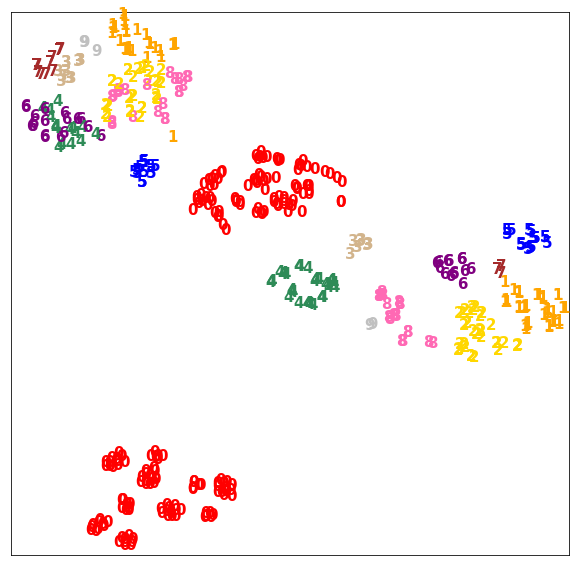

In [284]:
cluster_on(13, 0, 0+1, 8, 12+1)

['/'] [] /
['/'] [] /
['*'] [] *
['/'] [] /
['*'] [] *
[[ 6.44167542e-01  5.41660070e-01  8.91316712e-01 -7.41254508e-01
   1.67891860e+00 -2.60760993e-01 -2.14948356e-01 -5.17955601e-01
   1.13004005e+00 -1.13713287e-01]
 [-3.24329615e-01  1.31342554e+00  1.52033880e-01 -1.06139398e+00
  -1.66342700e+00 -1.19601178e+00 -5.94611049e-01 -1.73973751e+00
  -6.21738024e-02  1.96592128e+00]
 [ 3.21054745e-06  5.33271532e-07 -9.01948226e-07  5.22467474e-07
  -5.62351431e-07 -5.66456947e-07  2.85447470e-08 -9.29716180e-07
   1.61616413e-06  3.10055725e-06]
 [ 1.18776476e+00 -2.96253413e-01 -7.08195984e-01 -2.15986967e-02
  -1.33728111e+00 -3.12479198e-01 -4.00153130e-01 -7.72912085e-01
   6.10257685e-01  1.26013267e+00]
 [ 8.11569212e-09  7.42959916e-10 -8.18695334e-09 -5.12224874e-10
  -2.43576403e-09 -1.98787475e-09 -6.07434503e-09 -2.63571165e-10
  -6.04252559e-09  1.02445945e-08]]


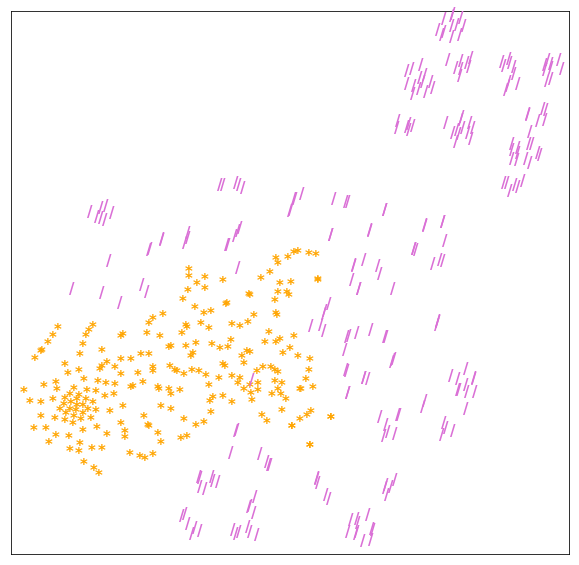

In [283]:
cluster_on(13, 1, 1+1, 13, 13+1)

['1', '-', '1', '/', '1', '*', '9', '-', '1', '/', '7', '*', '6', '/', '4'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 9
['5', '-', '5', '*', '6', '/', '6', '+', '4', '/', '4', '*', '1', '/', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 5
['8', '-', '6', '*', '5', '*', '6', '-', '1', '/', '1', '/', '6', '*', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 8
['8', '+', '8', '/', '1', '*', '8', '+', '8', '/', '8', '/', '5', '/', '4'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 8
['3', '+', '7', '*', '9', '*', '9', '-', '2', '*', '2', '*', '5', '*', '7'] [1, 5, 1, 2, 3, 4, 6, 7, 1, 2, 3, 4, 5, 6] 0
[[ 0.88268536  0.16617131 -2.45301723  0.55500019  0.04222036  0.28842312
  -0.05914257 -0.5536359   0.57065576  0.6423555 ]
 [ 0.47094616  0.86804128  0.13448848 -1.39342725 -1.52585793 -2.1117723
  -0.32405645 -1.26911545 -0.4858489   2.85690832]
 [ 0.94163024 -0.67112511  0.07460994  0.28470218 -0.9036994  -0.21264867
   0.36370447  0.4113757   0.58935338  1.02405787]
 [ 1.13836324 -0.4085

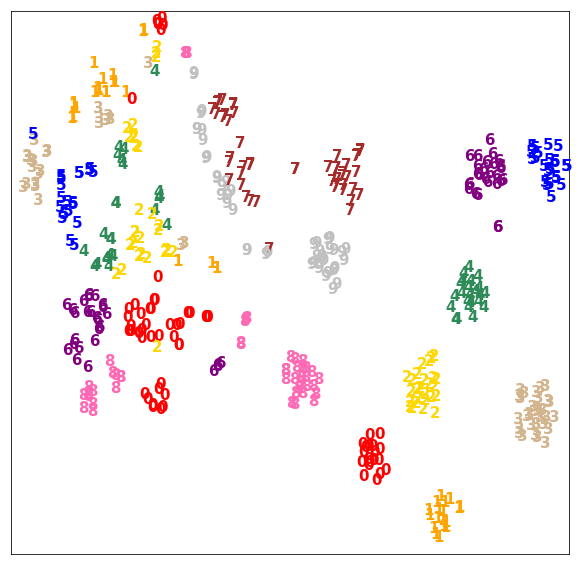

In [285]:
cluster_on(14, 0, 0+1, 0, 14+1)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.44699872  0.75146466 -1.20618296  0.20964776 -1.3355093  -0.68441582
  -0.06062535 -1.11081541 -0.63031447  1.14667046]
 [ 0.58145124  1.0492574   0.48956519 -1.441329   -0.10132145 -1.03319466
  -0.58103859 -0.82362938 -0.20368887  1.16896248]
 [ 1.02490973 -0.16164388 -0.19091204 -0.07989587 -0.39085647 -0.86011219
  -0.03784221 -0.24943657  0.13862249  1.8399421 ]
 [ 1.57744443  0.07719538 -0.82304156  0.15996058 -1.88466489 -0.20659184
   0.16686305 -1.06627774  0.56710231  0.54767364]
 [-0.26514    -0.6165179   0.09328311  0.47006956  0.98437935 -0.49537155
   0.60652238  0.60905629  0.17756101  0.59913325]]


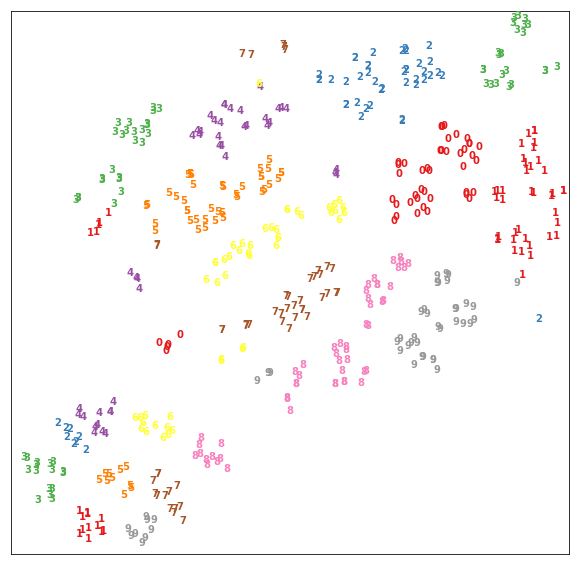

In [218]:
cluster_on(4, 0, 1+1, 0, 4+1)

['1', '-', '1', '/', '1'] [1, 5, 1, 2] 1
['5', '-', '5', '*', '6'] [1, 5, 1, 2] 5
['8', '-', '6', '*', '5'] [1, 5, 1, 2] 8
['8', '+', '8', '/', '1'] [1, 5, 1, 2] 8
['3', '+', '7', '*', '9'] [1, 5, 1, 2] 6
[[ 1.07560727e-05  1.30846847e-05 -2.63013335e-05  7.22546883e-06
  -4.64432560e-06  1.14022278e-05 -3.06583297e-06 -2.26415632e-05
  -1.60965265e-05  2.57448391e-05]
 [ 5.65744558e-05  1.38993491e-04 -2.26620323e-05 -6.35667384e-05
  -1.83357130e-04 -1.34324247e-04 -6.65734260e-05 -9.84897706e-05
  -8.91453165e-05  2.84282532e-06]
 [ 3.44779255e-05 -8.03788062e-05  7.36622223e-06  1.19846613e-04
  -3.71395981e-05  9.78060853e-05  1.20269622e-04  2.46427571e-05
  -9.93220747e-05 -1.73511929e-04]
 [ 6.77840035e-07  1.35814435e-06  4.81424081e-07 -1.45369211e-06
   2.40577651e-06  1.26526785e-07  2.45861482e-08  2.20963372e-07
   1.43977240e-06  3.04263449e-06]
 [-4.63509292e-04  2.47832882e-04  1.04491337e-04  3.76609270e-04
   1.41608805e-04 -1.07020278e-04  1.32773639e-04 -3.52277333

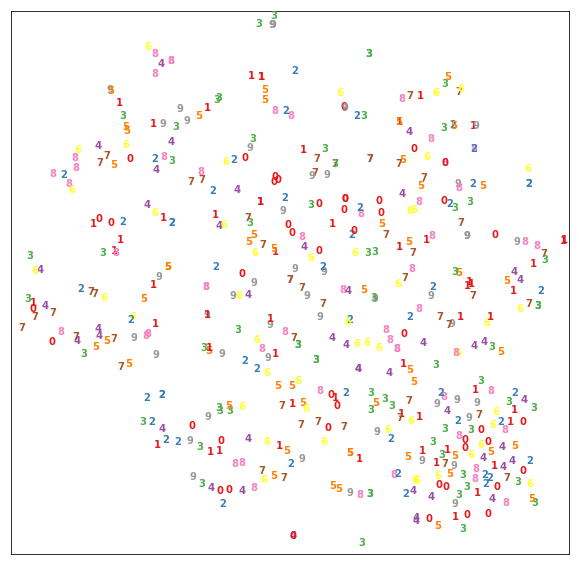

In [219]:
cluster_on(4, 1, 1+1, 0, 4+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.88416624e-01  5.17141640e-01 -4.37702835e-01  7.69149721e-01
  -7.51246810e-01  3.12622607e-01 -1.90200299e-01 -4.17003602e-01
  -7.58044541e-01  2.91299105e-01]
 [ 7.40018904e-01  9.01024282e-01  3.39055538e-01 -1.30989158e+00
  -3.76166344e-01 -1.39994633e+00 -4.66852248e-01 -9.15502906e-01
  -2.39567652e-01  1.33445966e+00]
 [ 6.89218998e-01 -4.15999919e-01 -2.70593733e-01  3.85751635e-01
  -1.03304482e+00 -3.61535668e-01  7.86744282e-02 -1.40522987e-01
   3.70958596e-02  1.74502397e+00]
 [ 8.21400702e-01 -4.59880561e-01  2.89513469e-01  9.54848481e-04
  -5.53351104e-01 -3.70677084e-01  2.21232191e-01  1.38796195e-01
   4.50875044e-01  1.36693609e+00]
 [-2.68568248e-01 -4.23972726e-01 -1.21514392e+

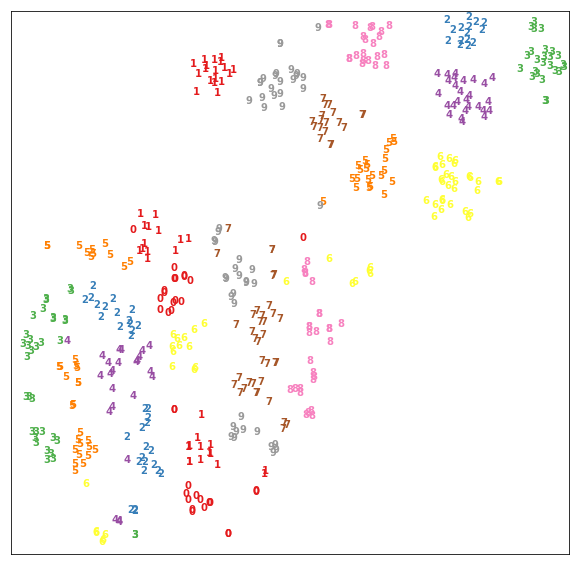

In [220]:
cluster_on(6, 0, 1+1, 0, 6+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 7.88416624e-01  5.17141640e-01 -4.37702835e-01  7.69149721e-01
  -7.51246810e-01  3.12622607e-01 -1.90200299e-01 -4.17003602e-01
  -7.58044541e-01  2.91299105e-01]
 [ 7.40018904e-01  9.01024282e-01  3.39055538e-01 -1.30989158e+00
  -3.76166344e-01 -1.39994633e+00 -4.66852248e-01 -9.15502906e-01
  -2.39567652e-01  1.33445966e+00]
 [ 6.89218998e-01 -4.15999919e-01 -2.70593733e-01  3.85751635e-01
  -1.03304482e+00 -3.61535668e-01  7.86744282e-02 -1.40522987e-01
   3.70958596e-02  1.74502397e+00]
 [ 8.21400702e-01 -4.59880561e-01  2.89513469e-01  9.54848481e-04
  -5.53351104e-01 -3.70677084e-01  2.21232191e-01  1.38796195e-01
   4.50875044e-01  1.36693609e+00]
 [-2.68568248e-01 -4.23972726e-01 -1.21514392e+

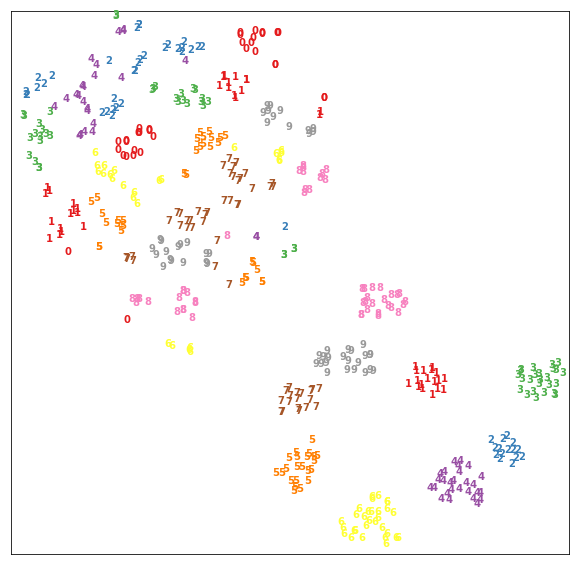

In [222]:
cluster_on(6, 0, 0+1, 0, 6+1)

['1', '-', '1', '/', '1', '*', '9'] [1, 5, 1, 2, 3, 4] 1
['5', '-', '5', '*', '6', '/', '6'] [1, 5, 1, 2, 3, 4] 5
['8', '-', '6', '*', '5', '*', '6'] [1, 5, 1, 2, 3, 4] 8
['8', '+', '8', '/', '1', '*', '8'] [1, 5, 1, 2, 3, 4] 8
['3', '+', '7', '*', '9', '*', '9'] [1, 5, 1, 2, 3, 4] 0
[[ 4.62593278e-04  2.40685826e-04 -3.99683835e-04  7.53745480e-05
  -3.73838673e-04 -9.99086915e-05 -2.73540092e-04 -2.22499639e-05
  -2.47009069e-04  2.02960175e-04]
 [ 1.10524446e-01  1.99405506e-01  9.29588377e-02 -2.73848265e-01
  -1.94101669e-02 -1.96436882e-01 -1.10426478e-01 -1.56539261e-01
  -3.87819968e-02  2.22134396e-01]
 [ 5.73534671e-05 -5.16631808e-05 -1.02961485e-05  3.74117153e-05
  -2.11436382e-05  2.76730862e-05  2.78176394e-05 -2.67387823e-05
   4.80112030e-05  2.90407970e-05]
 [ 2.40079709e-04 -1.26704384e-04 -2.77551851e-04  7.25145510e-05
  -4.91106941e-04  5.14397288e-05  6.47560373e-05 -4.71582316e-05
   1.50293927e-04  1.68957064e-04]
 [ 2.77392664e-05  3.51389521e-04  2.46060692e-

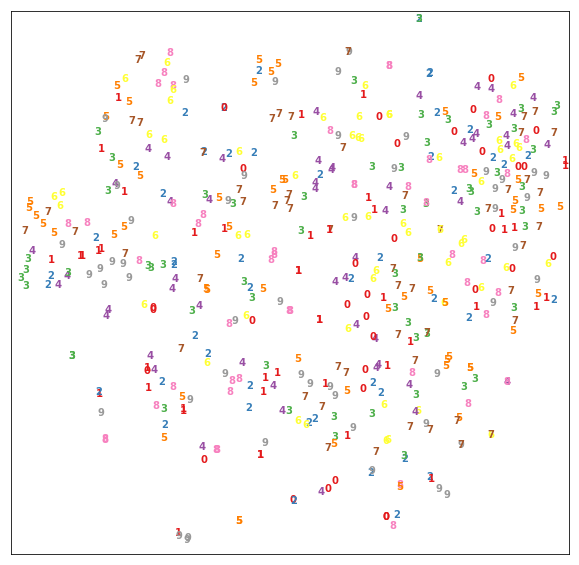

In [221]:
cluster_on(6, 1, 1+1, 0, 6+1)

['1', '-', '1', '/', '1'] [1, 2, 3, 4] 0
['5', '-', '5', '*', '6'] [1, 2, 3, 4] 0
['8', '-', '6', '*', '5'] [1, 2, 3, 4] 0
['8', '+', '8', '/', '1'] [1, 2, 3, 4] 0
['3', '+', '7', '*', '9'] [1, 2, 3, 4] 0
['4', '+', '9', '*', '8'] [1, 2, 3, 4] 4
['2', '+', '6', '/', '9'] [1, 2, 3, 4] 8
['9', '-', '5', '/', '8'] [1, 2, 3, 4] 4
['3', '+', '4', '*', '3'] [1, 2, 3, 4] 1
['9', '-', '8', '/', '2'] [1, 2, 3, 4] 1
['7', '-', '8', '/', '2'] [1, 2, 3, 4] 1
['7', '-', '3', '*', '6'] [1, 2, 3, 4] 4
['9', '-', '7', '/', '6'] [1, 2, 3, 4] 2
['7', '+', '4', '*', '2'] [1, 2, 3, 4] 2
['6', '+', '1', '/', '4'] [1, 2, 3, 4] 3
['9', '-', '2', '*', '7'] [1, 2, 3, 4] 9
['6', '-', '5', '/', '3'] [1, 2, 3, 4] 1
['6', '-', '2', '/', '2'] [1, 2, 3, 4] 0
['3', '+', '3', '/', '7'] [1, 2, 3, 4] 6
['2', '-', '4', '/', '2'] [1, 2, 3, 4] 0
['6', '-', '3', '/', '6'] [1, 2, 3, 4] 3
['5', '-', '7', '/', '7'] [1, 2, 3, 4] 1
['2', '-', '3', '*', '7'] [1, 2, 3, 4] 3
['7', '+', '4', '*', '4'] [1, 2, 3, 4] 4
['4', '+', '8', 

['8', '-', '2', '/', '9'] [1, 2, 3, 4] 6
['1', '+', '4', '*', '3'] [1, 2, 3, 4] 5
['1', '+', '7', '/', '1'] [1, 2, 3, 4] 0
['9', '+', '4', '/', '7'] [1, 2, 3, 4] 3
['9', '-', '1', '*', '4'] [1, 2, 3, 4] 2
['4', '-', '7', '*', '6'] [1, 2, 3, 4] 2
['1', '+', '2', '*', '1'] [1, 2, 3, 4] 3
['3', '-', '6', '*', '5'] [1, 2, 3, 4] 5
['2', '+', '2', '*', '5'] [1, 2, 3, 4] 0
['4', '+', '5', '*', '2'] [1, 2, 3, 4] 8
['4', '-', '8', '*', '4'] [1, 2, 3, 4] 4
['1', '+', '4', '*', '2'] [1, 2, 3, 4] 0
['8', '-', '6', '/', '6'] [1, 2, 3, 4] 2
['5', '+', '3', '/', '6'] [1, 2, 3, 4] 2
['8', '+', '1', '/', '1'] [1, 2, 3, 4] 0
['7', '-', '3', '*', '5'] [1, 2, 3, 4] 0
['3', '+', '8', '/', '4'] [1, 2, 3, 4] 1
['5', '+', '1', '*', '7'] [1, 2, 3, 4] 2
['6', '+', '5', '*', '9'] [1, 2, 3, 4] 9
['4', '+', '3', '*', '1'] [1, 2, 3, 4] 7
['2', '+', '6', '*', '2'] [1, 2, 3, 4] 6
['8', '+', '4', '*', '3'] [1, 2, 3, 4] 6
['6', '-', '3', '*', '8'] [1, 2, 3, 4] 4
['2', '-', '9', '*', '2'] [1, 2, 3, 4] 6
['6', '-', '4', 

['4', '+', '2', '/', '9'] [1, 2, 3, 4] 6
['1', '-', '1', '*', '4'] [1, 2, 3, 4] 0
['6', '-', '2', '/', '1'] [1, 2, 3, 4] 0
['2', '+', '6', '*', '8'] [1, 2, 3, 4] 4
['5', '-', '3', '*', '5'] [1, 2, 3, 4] 0
['3', '+', '5', '*', '9'] [1, 2, 3, 4] 2
['4', '-', '1', '/', '2'] [1, 2, 3, 4] 1
['1', '-', '5', '*', '8'] [1, 2, 3, 4] 8
['9', '+', '3', '/', '5'] [1, 2, 3, 4] 2
['9', '-', '2', '*', '9'] [1, 2, 3, 4] 3
['1', '-', '8', '/', '6'] [1, 2, 3, 4] 3
['9', '+', '9', '/', '6'] [1, 2, 3, 4] 2
['2', '-', '9', '/', '1'] [1, 2, 3, 4] 0
['6', '-', '9', '*', '2'] [1, 2, 3, 4] 4
['9', '-', '7', '*', '4'] [1, 2, 3, 4] 8
['7', '-', '3', '*', '8'] [1, 2, 3, 4] 2
['8', '-', '3', '/', '3'] [1, 2, 3, 4] 2
['4', '+', '4', '/', '3'] [1, 2, 3, 4] 2
['6', '+', '5', '*', '5'] [1, 2, 3, 4] 5
['1', '-', '2', '/', '8'] [1, 2, 3, 4] 1
['2', '+', '6', '/', '6'] [1, 2, 3, 4] 2
['7', '-', '5', '/', '1'] [1, 2, 3, 4] 0
['9', '+', '9', '*', '3'] [1, 2, 3, 4] 4
['2', '+', '4', '/', '3'] [1, 2, 3, 4] 0
['9', '+', '6', 

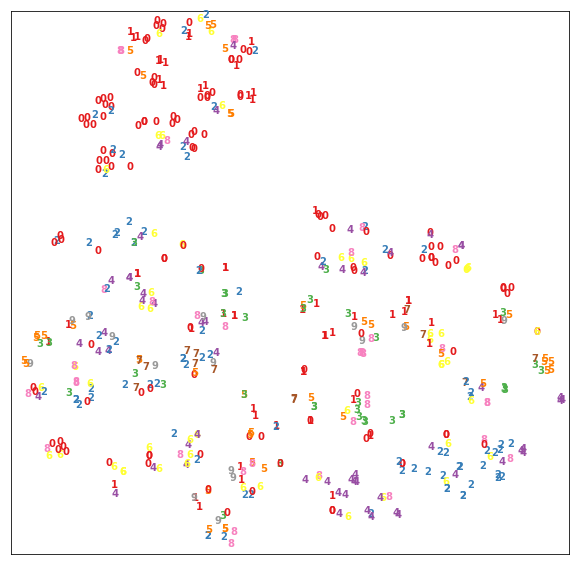

In [181]:
cluster_on(4, 1, 1+1, 0, 4+1)

['1', '/', '7', '*', '6', '/', '4'] [1, 2, 3, 4, 5, 6] 2
['4', '/', '4', '*', '1', '/', '7'] [1, 2, 3, 4, 5, 6] 0
['1', '/', '1', '/', '6', '*', '7'] [1, 2, 3, 4, 5, 6] 0
['8', '/', '8', '/', '5', '/', '4'] [1, 2, 3, 4, 5, 6] 0
['2', '*', '2', '*', '5', '*', '7'] [1, 2, 3, 4, 5, 6] 0
['9', '*', '6', '/', '3', '/', '4'] [1, 2, 3, 4, 5, 6] 1
['6', '/', '7', '/', '9', '/', '5'] [1, 2, 3, 4, 5, 6] 1
['5', '*', '2', '*', '9', '/', '9'] [1, 2, 3, 4, 5, 6] 0
['2', '/', '2', '/', '6', '/', '9'] [1, 2, 3, 4, 5, 6] 0
['6', '*', '8', '*', '5', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['9', '*', '5', '*', '1', '*', '7'] [1, 2, 3, 4, 5, 6] 5
['1', '/', '6', '/', '8', '*', '9'] [1, 2, 3, 4, 5, 6] 9
['3', '*', '7', '*', '1', '*', '2'] [1, 2, 3, 4, 5, 6] 2
['9', '*', '1', '*', '5', '/', '5'] [1, 2, 3, 4, 5, 6] 0
['4', '/', '9', '*', '7', '*', '4'] [1, 2, 3, 4, 5, 6] 2
['5', '/', '3', '*', '6', '*', '5'] [1, 2, 3, 4, 5, 6] 0
['9', '/', '8', '*', '6', '/', '2'] [1, 2, 3, 4, 5, 6] 0
['2', '*', '1', '/', '4', '*', 

['6', '/', '5', '/', '9', '*', '8'] [1, 2, 3, 4, 5, 6] 8
['7', '/', '8', '/', '2', '*', '4'] [1, 2, 3, 4, 5, 6] 4
['5', '*', '9', '*', '2', '*', '3'] [1, 2, 3, 4, 5, 6] 0
['7', '*', '4', '*', '8', '*', '7'] [1, 2, 3, 4, 5, 6] 8
['5', '*', '5', '*', '4', '/', '8'] [1, 2, 3, 4, 5, 6] 0
['3', '/', '2', '/', '6', '*', '5'] [1, 2, 3, 4, 5, 6] 5
['6', '/', '6', '/', '3', '/', '6'] [1, 2, 3, 4, 5, 6] 0
['8', '/', '3', '*', '2', '*', '1'] [1, 2, 3, 4, 5, 6] 4
['7', '/', '4', '/', '4', '*', '2'] [1, 2, 3, 4, 5, 6] 6
['1', '*', '8', '*', '1', '/', '2'] [1, 2, 3, 4, 5, 6] 0
['8', '*', '9', '/', '6', '*', '8'] [1, 2, 3, 4, 5, 6] 6
['5', '*', '2', '/', '5', '/', '5'] [1, 2, 3, 4, 5, 6] 0
['7', '*', '4', '/', '1', '*', '4'] [1, 2, 3, 4, 5, 6] 0
['2', '*', '8', '*', '3', '*', '7'] [1, 2, 3, 4, 5, 6] 6
['5', '/', '8', '*', '9', '*', '9'] [1, 2, 3, 4, 5, 6] 5
['4', '/', '8', '/', '6', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['8', '*', '5', '*', '9', '/', '4'] [1, 2, 3, 4, 5, 6] 0
['9', '/', '6', '*', '4', '*', 

['2', '*', '4', '/', '9', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['7', '/', '4', '*', '9', '/', '4'] [1, 2, 3, 4, 5, 6] 3
['2', '*', '7', '*', '1', '/', '6'] [1, 2, 3, 4, 5, 6] 4
['7', '*', '5', '/', '3', '*', '8'] [1, 2, 3, 4, 5, 6] 6
['7', '*', '6', '*', '5', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['7', '*', '1', '*', '1', '/', '2'] [1, 2, 3, 4, 5, 6] 1
['7', '*', '6', '*', '2', '/', '5'] [1, 2, 3, 4, 5, 6] 4
['5', '*', '8', '/', '1', '/', '7'] [1, 2, 3, 4, 5, 6] 0
['9', '*', '7', '*', '1', '/', '4'] [1, 2, 3, 4, 5, 6] 3
['9', '/', '7', '*', '4', '*', '4'] [1, 2, 3, 4, 5, 6] 2
['1', '*', '8', '/', '7', '/', '9'] [1, 2, 3, 4, 5, 6] 1
['4', '/', '5', '/', '2', '/', '3'] [1, 2, 3, 4, 5, 6] 0
['5', '*', '3', '*', '9', '/', '4'] [1, 2, 3, 4, 5, 6] 1
['2', '/', '2', '*', '9', '*', '7'] [1, 2, 3, 4, 5, 6] 0
['4', '/', '3', '/', '5', '/', '3'] [1, 2, 3, 4, 5, 6] 1
['2', '*', '2', '/', '4', '*', '6'] [1, 2, 3, 4, 5, 6] 0
['6', '/', '8', '*', '7', '*', '1'] [1, 2, 3, 4, 5, 6] 2
['6', '*', '1', '/', '3', '*', 

['4', '*', '1', '/', '8', '*', '7'] [1, 2, 3, 4, 5, 6] 8
['7', '/', '1', '/', '8', '*', '4'] [1, 2, 3, 4, 5, 6] 0
['9', '*', '3', '*', '7', '/', '5'] [1, 2, 3, 4, 5, 6] 4
['8', '/', '4', '/', '6', '/', '7'] [1, 2, 3, 4, 5, 6] 0
['9', '*', '9', '/', '7', '/', '4'] [1, 2, 3, 4, 5, 6] 1
['2', '*', '5', '*', '3', '/', '5'] [1, 2, 3, 4, 5, 6] 0
['8', '*', '3', '/', '8', '/', '7'] [1, 2, 3, 4, 5, 6] 4
['1', '/', '1', '/', '7', '*', '8'] [1, 2, 3, 4, 5, 6] 0
['4', '*', '6', '/', '3', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['4', '/', '3', '/', '4', '/', '6'] [1, 2, 3, 4, 5, 6] 1
['6', '/', '6', '/', '7', '*', '5'] [1, 2, 3, 4, 5, 6] 0
['6', '*', '4', '/', '9', '*', '8'] [1, 2, 3, 4, 5, 6] 2
['7', '/', '7', '/', '5', '*', '4'] [1, 2, 3, 4, 5, 6] 0
['3', '*', '1', '*', '4', '/', '8'] [1, 2, 3, 4, 5, 6] 2
['6', '/', '2', '*', '9', '*', '5'] [1, 2, 3, 4, 5, 6] 0
['6', '/', '7', '/', '3', '/', '1'] [1, 2, 3, 4, 5, 6] 0
['6', '*', '9', '*', '9', '*', '4'] [1, 2, 3, 4, 5, 6] 4
['7', '*', '1', '/', '2', '*', 

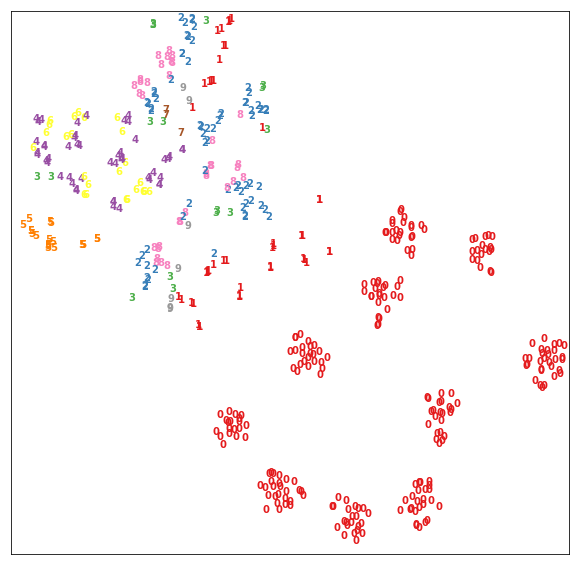

In [180]:
cluster_on(14, 0, 0+1, 8, 14+1)

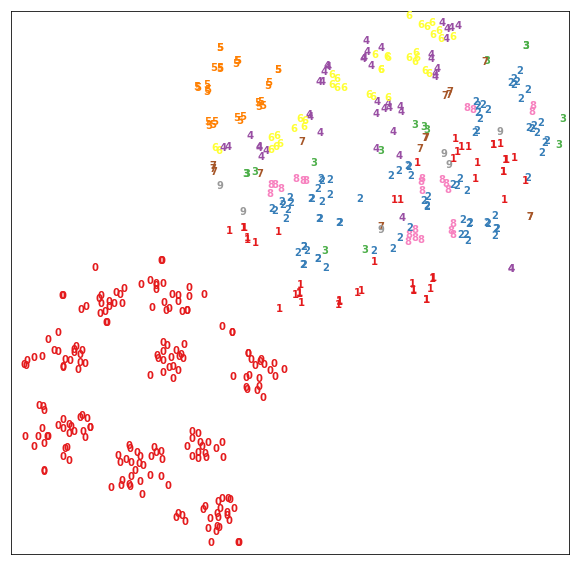

In [163]:
cluster_on(6, 0, 1+1, 2, 6+1)

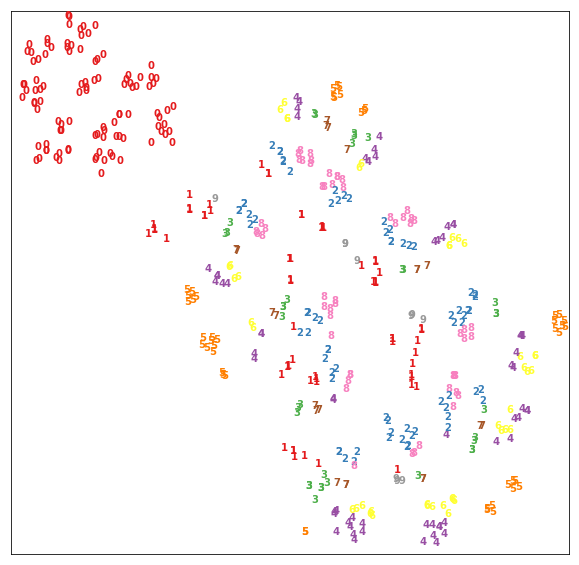

In [164]:
cluster_on(4, 0, 1+1, 2, 4+1)

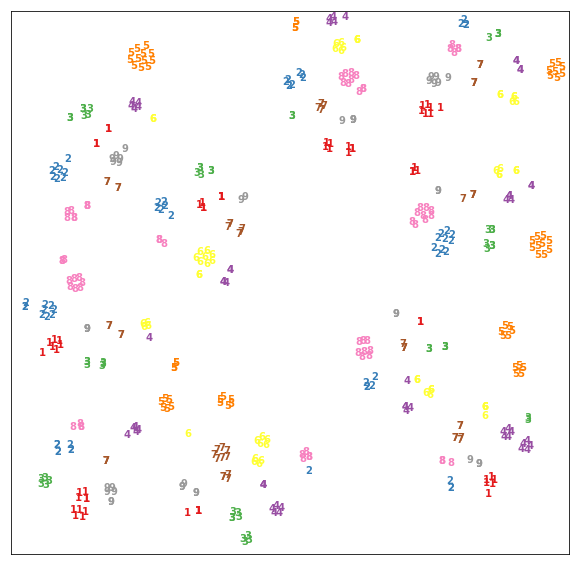

In [165]:
cluster_on(2, 0, 0+1, 2, 2+1)

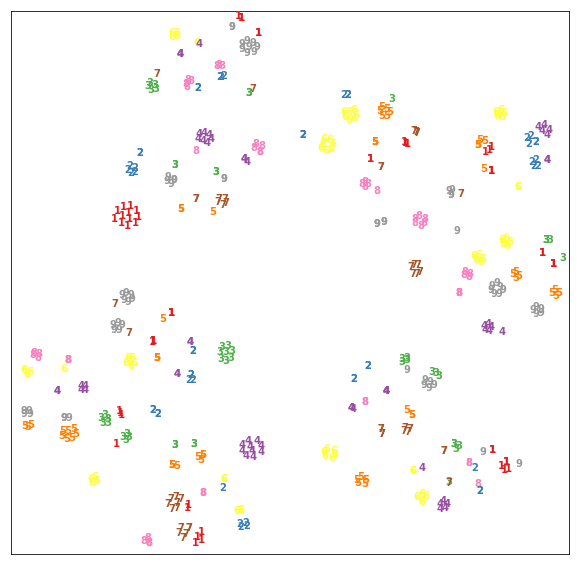

In [166]:
cluster_on(2, 0, 0+1, 0, 0+1)

# + -

In [161]:
expr = '4 + 9 + 9 + 5 + 9'.split()
ds = [int(d) for d in '1 2 3 4 5 6 7 8'.split()]
h = 8

In [162]:
res = regen(expr, ds, h, 1000)

(array([106., 101.,  94.,  85., 101., 129., 105.,  91.,  94.,  94.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

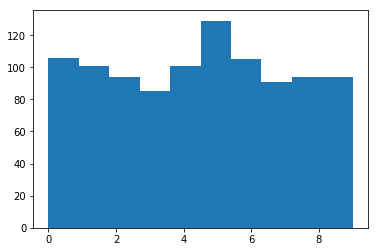

In [163]:
plt.hist([int(r[-1]) for r in res])

In [164]:
with open('analy_clustering_plus_minus.tsv', 'w') as f:
    for r in res:
        to_write = [' '.join(r[0]), ' '.join(r[1]), str(r[2]), str(r[3])]
        f.write('\t'.join(to_write)+'\n')

([], <a list of 0 Text yticklabel objects>)

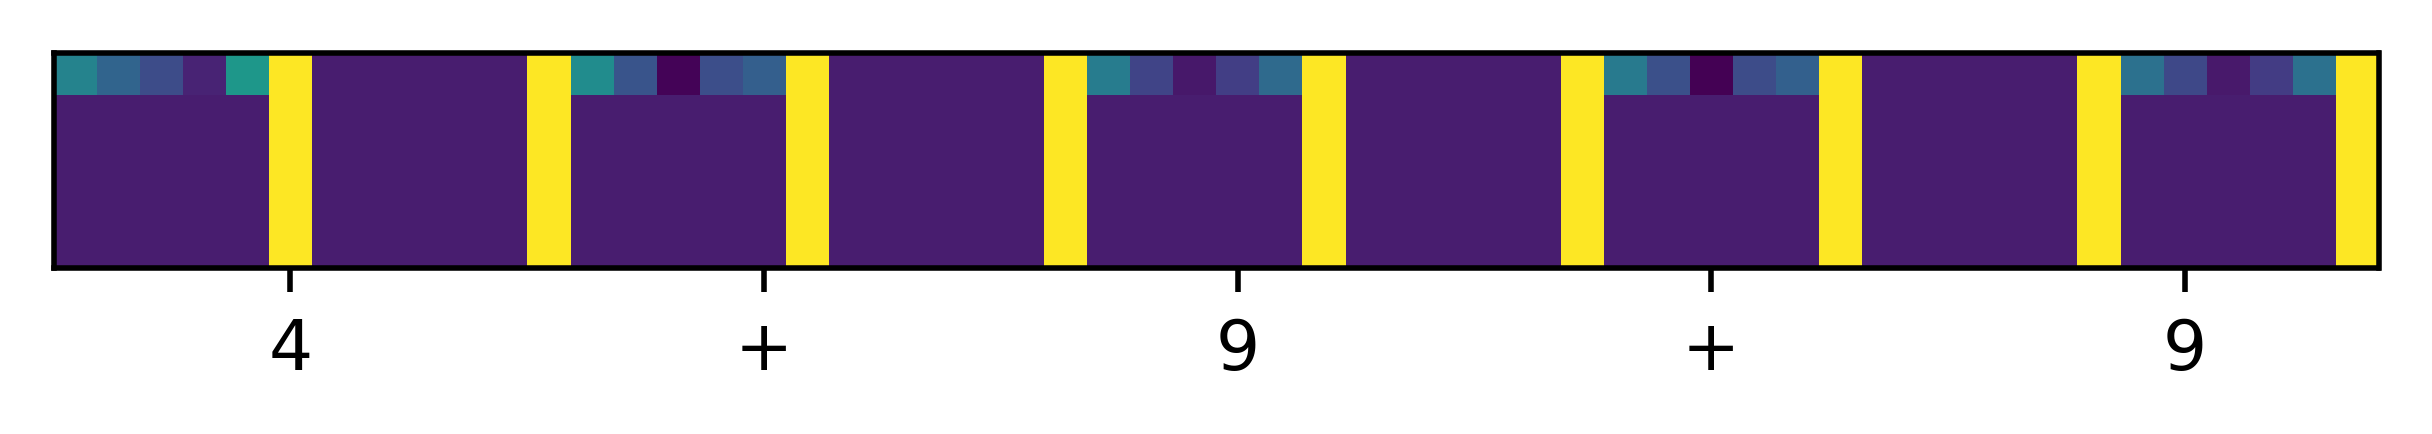

In [173]:
seq = '4+9+9+5+9'
syn_dis = [1, 2, 3, 4, 5, 6, 7, 8]
seq_len = len(seq)
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}
i = 0
with open('feval-analy_clustering_plus_minus-sarnn.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if 'all' not in line_json:
            continue
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])
        i += 1
        i %= seq_len
remain = 5
step = []
for i in range(seq_len):
    step.append(np.array(mem[i]))
mean_mem_dist = []
for i in range(seq_len):
    mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])
step = []
for i in range(seq_len):
    step.append(np.array(prob_action[i]))
mean_dist = []
for i in range(seq_len):
    mean_dist.append(step[i].sum(0)/step[i].shape[0])
for i in range(seq_len):
    mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
mem_whole = np.hstack(mean_mem_dist)
fig, ax = plt.subplots()
fig.dpi = 500
plt.imshow(mem_whole)
plt.xticks(np.arange(5, mem_whole.shape[1], 11), list(seq))
plt.yticks([])

# * /

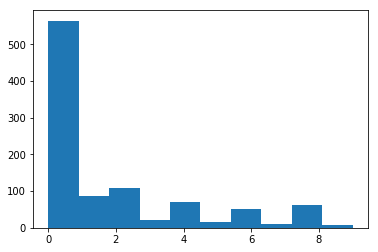

In [184]:
expr = '4 * 9 * 9 * 5 * 9'.split()
ds = [int(d) for d in '1 2 3 4 5 6 7 8'.split()]
h = 8
res = regen(expr, ds, h, 1000)
plt.hist([int(r[-1]) for r in res])
with open('analy_clustering_prod_div.tsv', 'w') as f:
    for r in res:
        to_write = [' '.join(r[0]), ' '.join(r[1]), str(r[2]), str(r[3])]
        f.write('\t'.join(to_write)+'\n')

([], <a list of 0 Text yticklabel objects>)

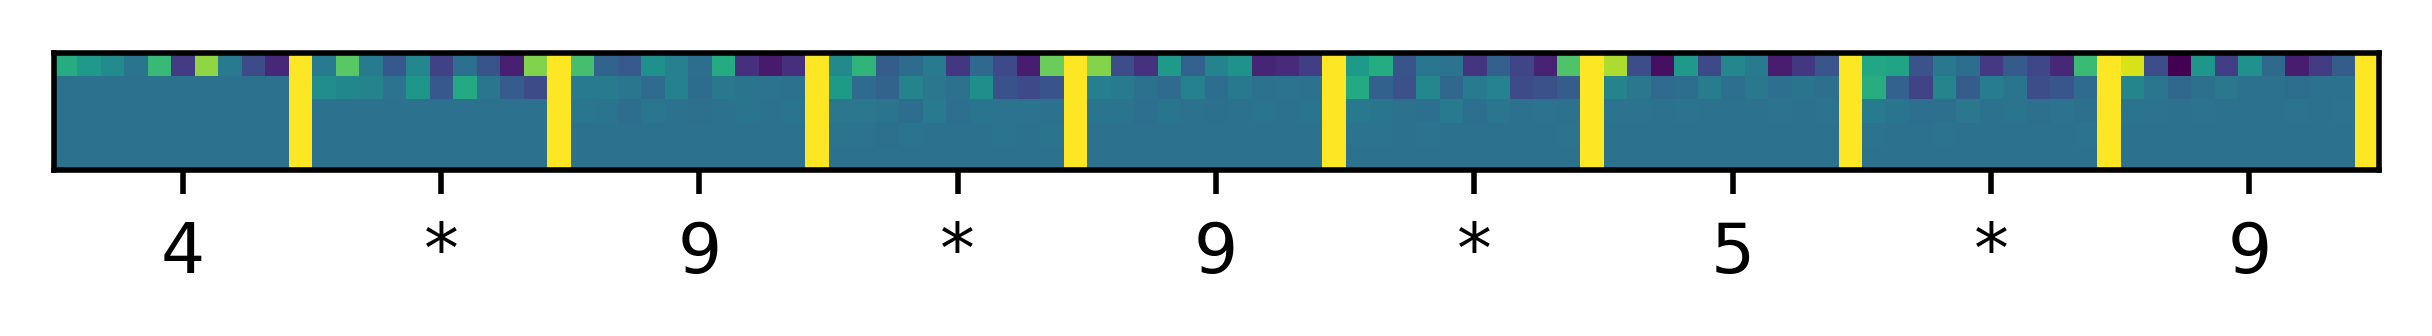

In [160]:
seq = '4*9*9*5*9'
syn_dis = [1, 2, 3, 4, 5, 6, 7, 8]
seq_len = len(seq)
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}
i = 0
with open('feval-analy_clustering-sarnn.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if 'all' not in line_json:
            continue
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])
        i += 1
        i %= seq_len
remain = 10
step = []
for i in range(seq_len):
    step.append(np.array(mem[i]))
mean_mem_dist = []
for i in range(seq_len):
    mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])
step = []
for i in range(seq_len):
    step.append(np.array(prob_action[i]))
mean_dist = []
for i in range(seq_len):
    mean_dist.append(step[i].sum(0)/step[i].shape[0])
for i in range(seq_len):
    mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
mem_whole = np.hstack(mean_mem_dist)
fig, ax = plt.subplots()
fig.dpi = 500
plt.imshow(mem_whole)
plt.xticks(np.arange(5, mem_whole.shape[1], 11), list(seq))
plt.yticks([])

# better color

In [ ]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)